PICTURES FOR DATASET-1

PubMed Diabetes files already extracted.
Confirmed: C:/Users/ch.nayanesh reddy/OneDrive/Desktop/python face/pubmed-diabetes/pubmed-diabetes/data/Pubmed-Diabetes.NODE.paper.tab exists.
Confirmed: C:/Users/ch.nayanesh reddy/OneDrive/Desktop/python face/pubmed-diabetes/pubmed-diabetes/data/Pubmed-Diabetes.DIRECTED.cites.tab exists.
Confirmed: C:/Users/ch.nayanesh reddy/OneDrive/Desktop/python face/pubmed-diabetes/pubmed-diabetes/data/Pubmed-Diabetes.GRAPH.pubmed.tab exists.

Loading Pubmed-Diabetes.NODE.paper.tab...
Original Size: (19719, 2)
Assigning labels based on text content...
Assigned Label Distribution:
 label
3    19138
1      311
2      270
Name: count, dtype: int64


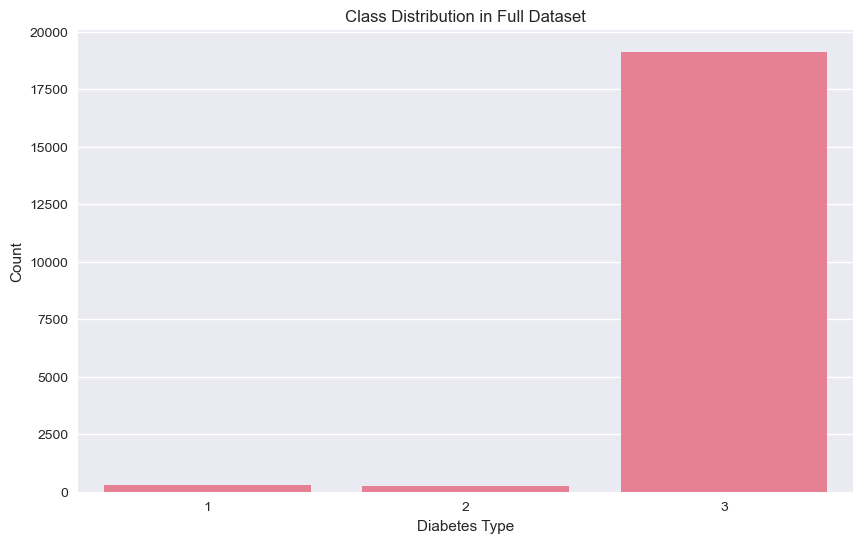


Loading Pubmed-Diabetes.DIRECTED.cites.tab...
Total lines in file: 44340
Skipped line 1: DIRECTED	cites
Skipped line 2: NO_FEATURES
Cites Size: (44338, 2)

Subsetting data with citation consideration and balanced classes...
Subset Size: (1581, 3)
Label Distribution:
 label
3    1000
1     311
2     270
Name: count, dtype: int64


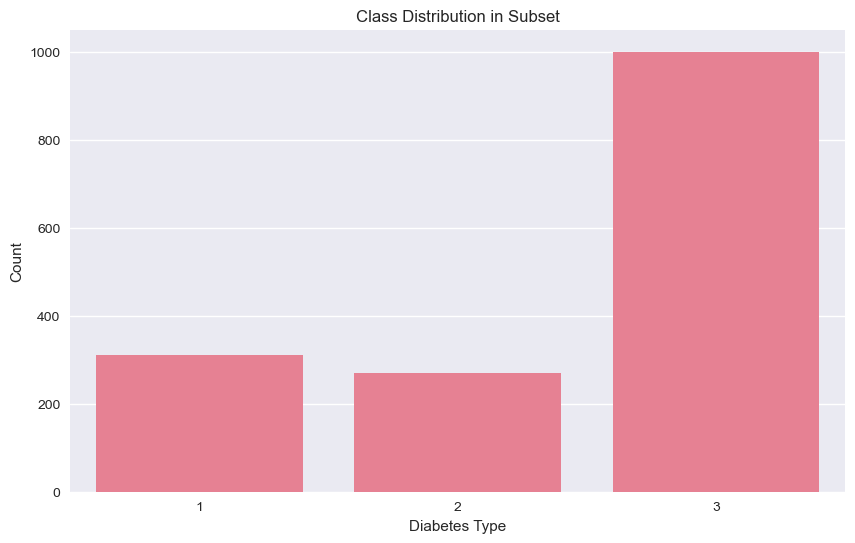

With Citations Preview:
          id                                               text  label  \
0  19956098  label=2\tw-use=0.011895300393253583\tw-studi=0...      1   
1  18367670  label=2\tw-common=0.04856662202153919\tw-contr...      1   
2  17983444  label=2\tw-anim=0.022550346593980093\tw-abnorm...      1   
3  19128359  label=2\tw-studi=0.009715759256257438\tw-contr...      1   
4  18205952  label=2\tw-common=0.022751931037117458\tw-use=...      1   

   citation_count  
0            22.0  
1            18.0  
2            15.0  
3            19.0  
4            12.0  


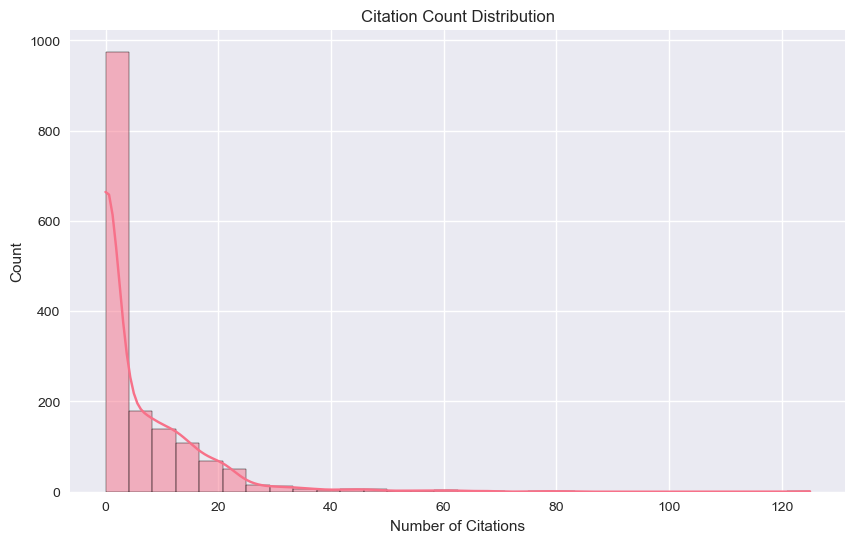


Enhanced Feature Engineering for High Accuracy...


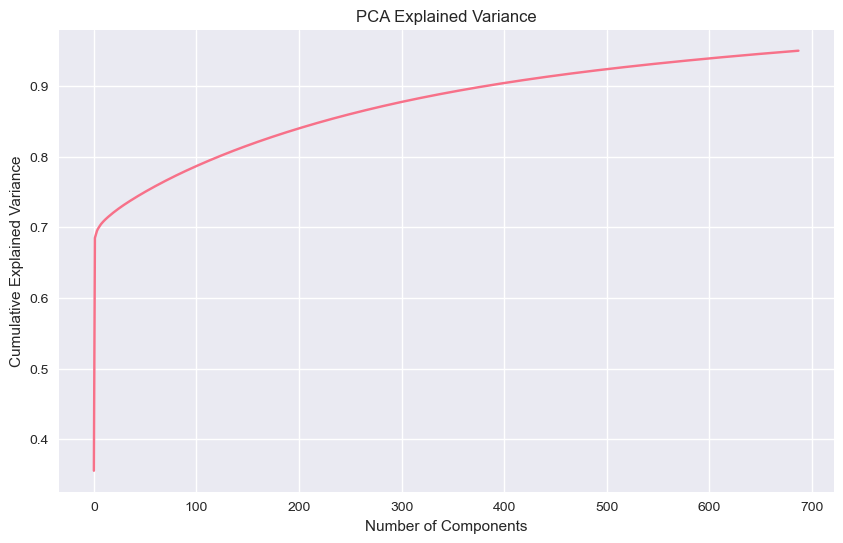


Class weights: {0: 1.6945337620578778, 1: 1.951851851851852, 2: 0.527}


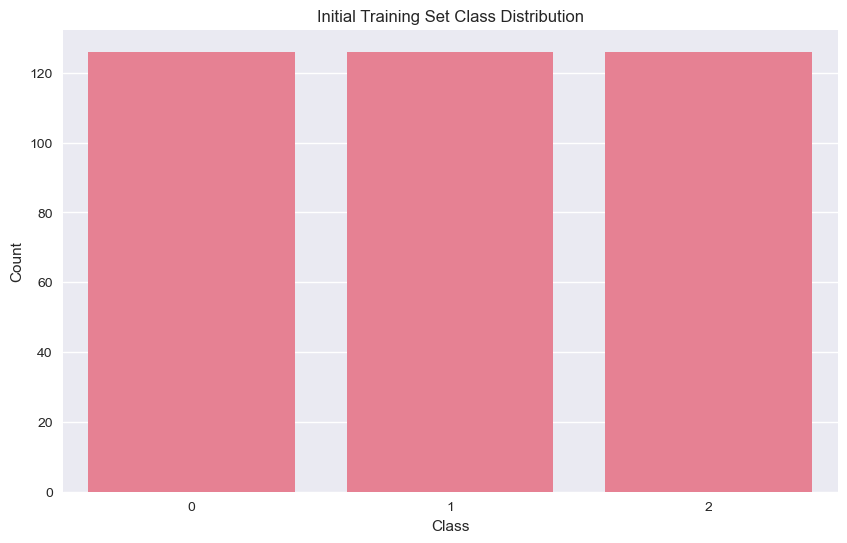


Training Hybrid Model (SVM + Random Forest)...
Iteration 1: Val F1 = 0.5920, Test Accuracy = 0.5457, F1 = 0.5548
Added 60 samples (Batch Size: 100)
Iteration 2: Val F1 = 0.5167, Test Accuracy = 0.6120, F1 = 0.6303
Added 60 samples (Batch Size: 100)
Iteration 3: Val F1 = 0.5506, Test Accuracy = 0.6467, F1 = 0.6589
Added 60 samples (Batch Size: 100)
Iteration 4: Val F1 = 0.5660, Test Accuracy = 0.7256, F1 = 0.7231
Added 60 samples (Batch Size: 100)
Iteration 5: Val F1 = 0.4801, Test Accuracy = 0.7192, F1 = 0.6946
Added 59 samples (Batch Size: 100)
Iteration 6: Val F1 = 0.3694, Test Accuracy = 0.6877, F1 = 0.6023
Early stopping at iteration 6


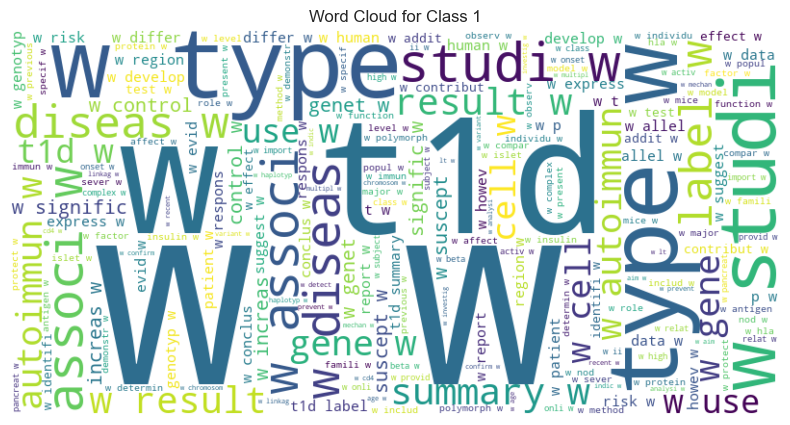

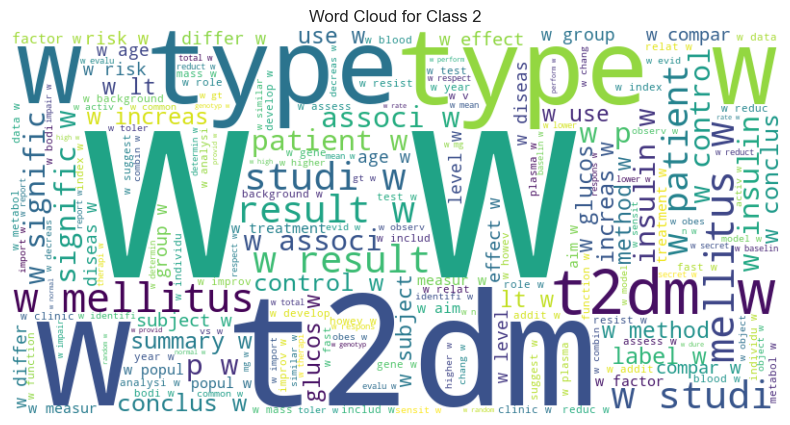

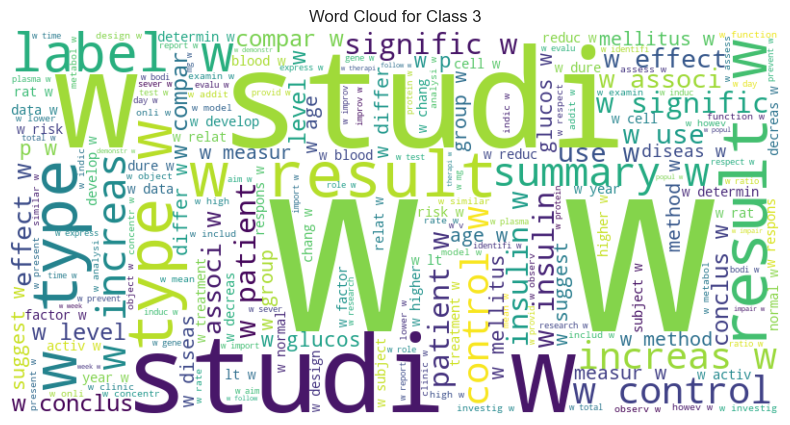


Detailed Classification Report:
              precision    recall  f1-score   support

      Type 1       1.00      0.15      0.25        62
      Type 2       1.00      0.15      0.26        54
       Other       0.67      1.00      0.80       201

    accuracy                           0.69       317
   macro avg       0.89      0.43      0.44       317
weighted avg       0.79      0.69      0.60       317



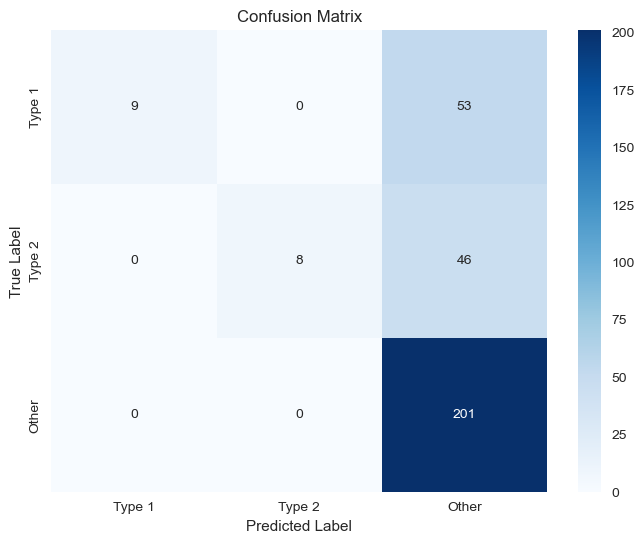

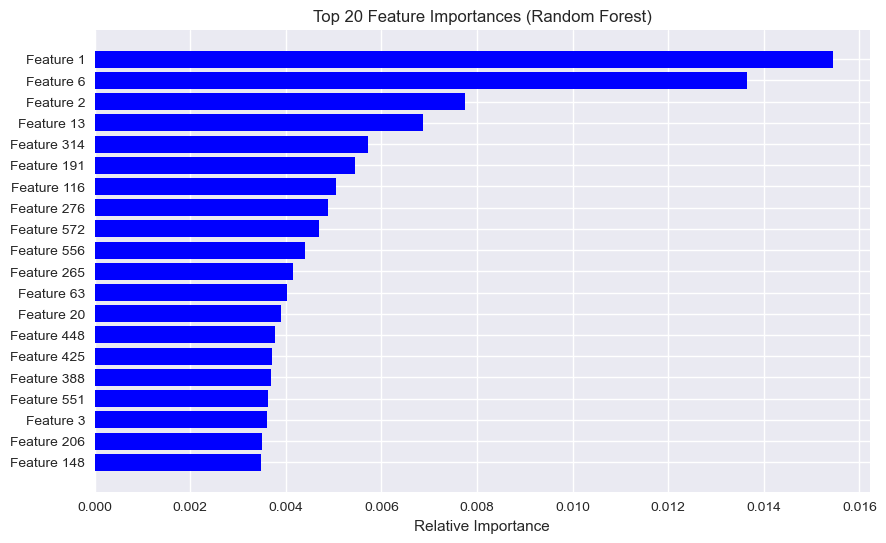


Processed PubMed Dataset Saved to: C:/Users/ch.nayanesh reddy/OneDrive/Desktop/python face/pubmed_processed.csv

Dataset Summary:
Rows: 1581, Columns: 4
Unique Labels: 3

Hybrid Model Final Performance:
Accuracy: 68.77%
F1-Score: 60.23%


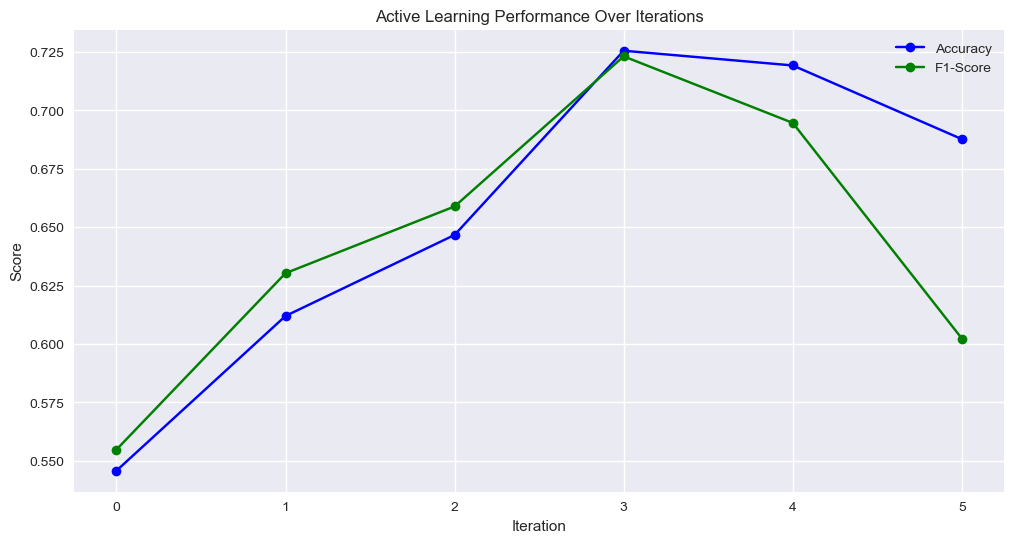

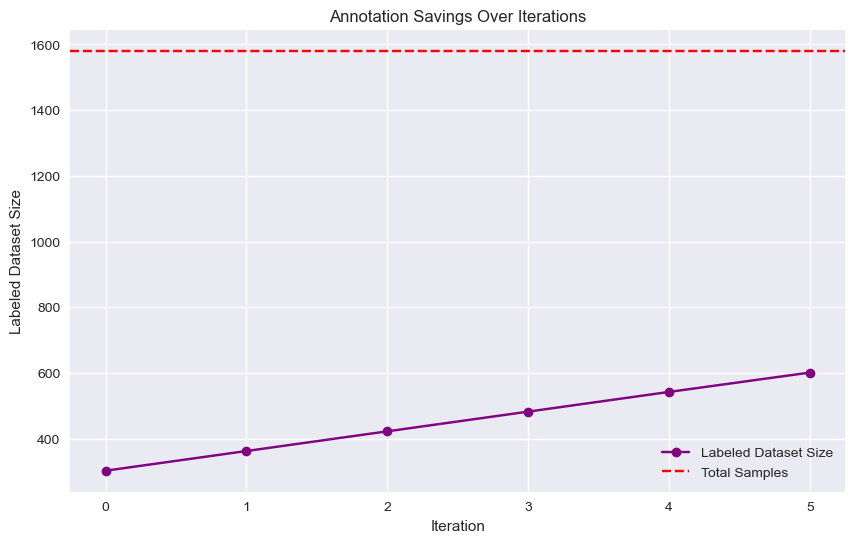

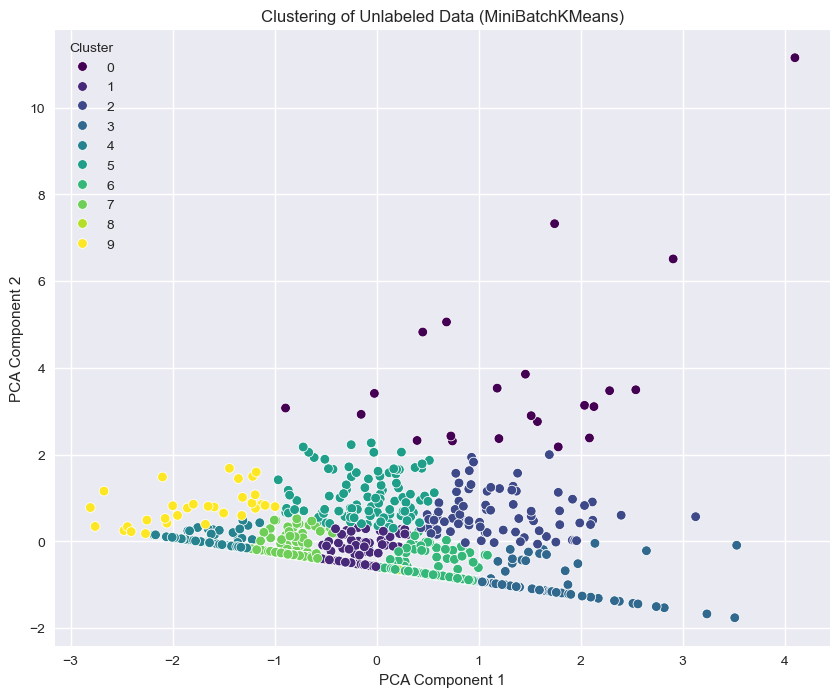

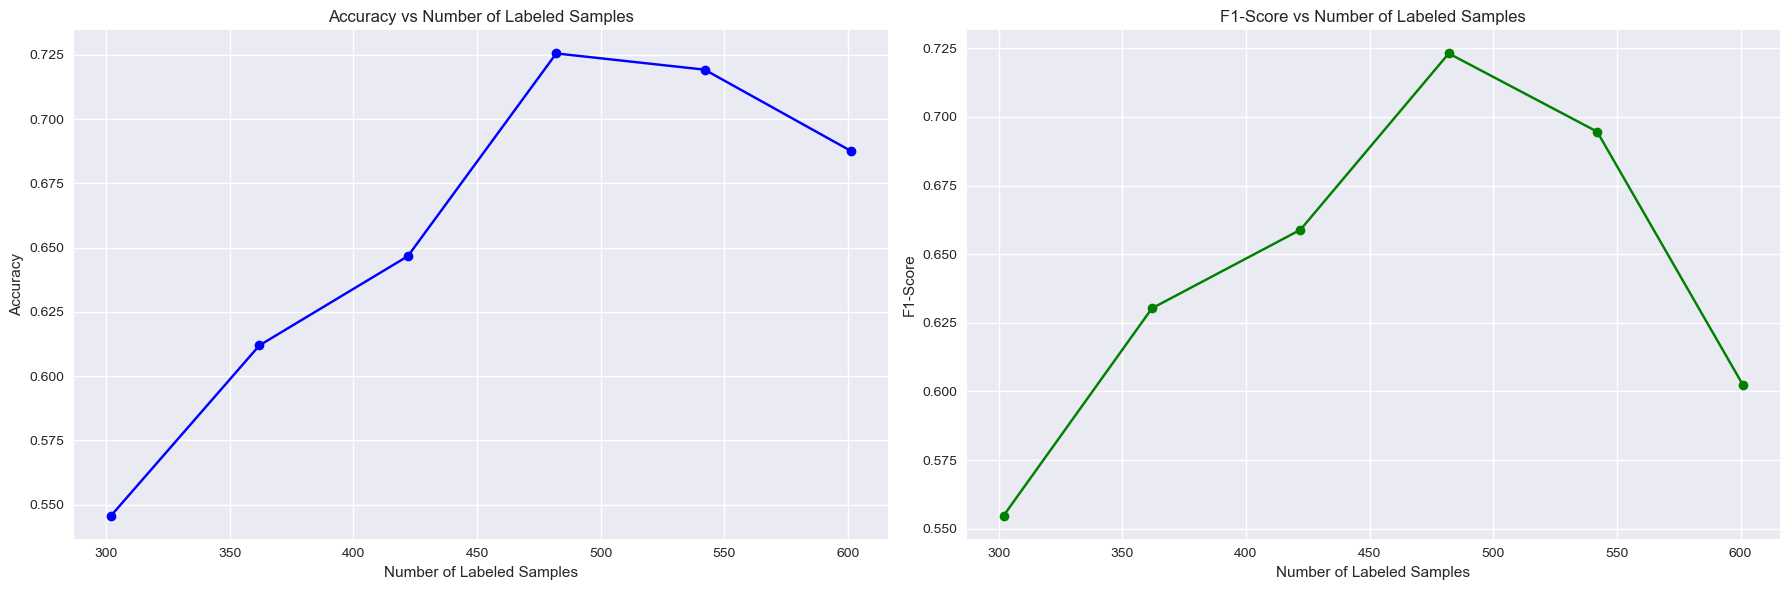

In [15]:
import pandas as pd
import zipfile
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Set style for plots
plt.style.use('seaborn')
sns.set_palette("husl")

# Paths
pubmed_zip = "C:/Users/ch.nayanesh reddy/OneDrive/Desktop/python face/pubmed-diabetes.zip"
output_dir = "C:/Users/ch.nayanesh reddy/OneDrive/Desktop/python face/"
extracted_dir = os.path.join(output_dir, "pubmed-diabetes/pubmed-diabetes/data/")
pubmed_node_file = os.path.join(extracted_dir, "Pubmed-Diabetes.NODE.paper.tab")
pubmed_cites_file = os.path.join(extracted_dir, "Pubmed-Diabetes.DIRECTED.cites.tab")
pubmed_graph_file = os.path.join(extracted_dir, "Pubmed-Diabetes.GRAPH.pubmed.tab")

# Step 1: Extract ZIP
if not os.path.exists(extracted_dir):
    print("Extracting PubMed Diabetes ZIP...")
    with zipfile.ZipFile(pubmed_zip, "r") as zip_ref:
        zip_ref.extractall(output_dir)
    print(f"Extracted to: {extracted_dir}")
else:
    print("PubMed Diabetes files already extracted.")

# Verify file existence
for filepath in [pubmed_node_file, pubmed_cites_file, pubmed_graph_file]:
    print(f"Confirmed: {filepath} exists." if os.path.exists(filepath) else f"Error: {filepath} does not exist!")

# Step 2: Load NODE.paper.tab
print("\nLoading Pubmed-Diabetes.NODE.paper.tab...")
data = []
with open(pubmed_node_file, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) < 2:
            continue
        paper_id = parts[0]
        abstract_idx = max((i for i, part in enumerate(parts) if ":" in part), default=0) + 1
        abstract = "\t".join(parts[abstract_idx:]) if abstract_idx < len(parts) else ""
        data.append([paper_id, abstract])

pubmed_df = pd.DataFrame(data, columns=["id", "text"])
print("Original Size:", pubmed_df.shape)

# Assign labels
print("Assigning labels based on text content...")
def assign_label(text):
    text_lower = text.lower()
    if any(kw in text_lower for kw in ["type 1", "insulin-dependent", "t1d", "juvenile"]):
        return 1
    elif any(kw in text_lower for kw in ["type 2", "non-insulin-dependent", "t2d", "adult-onset"]):
        return 2
    else:
        return 3

pubmed_df["label"] = pubmed_df["text"].apply(assign_label)
print("Assigned Label Distribution:\n", pubmed_df["label"].value_counts())

# Visualize label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=pubmed_df)
plt.title('Class Distribution in Full Dataset')
plt.xlabel('Diabetes Type')
plt.ylabel('Count')
plt.show()

# Step 3: Load DIRECTED.cites.tab
print("\nLoading Pubmed-Diabetes.DIRECTED.cites.tab...")
cites_data = []
with open(pubmed_cites_file, "r", encoding="utf-8") as f:
    lines = f.readlines()
    print(f"Total lines in file: {len(lines)}")
    for i, line in enumerate(lines):
        parts = line.strip().split("\t")
        if i < 2 or len(parts) < 4:
            print(f"Skipped line {i+1}: {line.strip()}")
            continue
        source_id = parts[1].replace("paper:", "")
        target_id = parts[3].replace("paper:", "")
        if source_id.isdigit() and target_id.isdigit():
            cites_data.append([source_id, target_id])
        else:
            print(f"Skipped line {i+1}: {line.strip()} (Invalid IDs)")

cites_df = pd.DataFrame(cites_data, columns=["source_id", "target_id"])
print("Cites Size:", cites_df.shape)

# Calculate citation counts
citation_counts = cites_df["source_id"].value_counts().reset_index()
citation_counts.columns = ["id", "citation_count"]
citation_counts["id"] = citation_counts["id"].astype(str)
pubmed_df["id"] = pubmed_df["id"].astype(str)

# Subset to 2,000 with balanced classes
print("\nSubsetting data with citation consideration and balanced classes...")
cited_ids = set(citation_counts["id"])
pubmed_cited = pubmed_df[pubmed_df["id"].isin(cited_ids)]
pubmed_uncited = pubmed_df[~pubmed_df["id"].isin(cited_ids)]

# Get balanced samples per class
def get_balanced_samples(df, n_samples):
    samples = []
    for label in [1, 2, 3]:
        label_samples = df[df["label"] == label]
        samples.append(label_samples.sample(min(n_samples, len(label_samples)), random_state=42))
    return pd.concat(samples)

pubmed_cited = get_balanced_samples(pubmed_cited, 500)
pubmed_uncited = get_balanced_samples(pubmed_uncited, 500)

pubmed_subset = pd.concat([pubmed_cited, pubmed_uncited]).reset_index(drop=True)
print("Subset Size:", pubmed_subset.shape)
print("Label Distribution:\n", pubmed_subset["label"].value_counts())

# Visualize subset label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=pubmed_subset)
plt.title('Class Distribution in Subset')
plt.xlabel('Diabetes Type')
plt.ylabel('Count')
plt.show()

# Merge citation counts
pubmed_subset = pubmed_subset.merge(citation_counts, on="id", how="left").fillna({"citation_count": 0})
print("With Citations Preview:\n", pubmed_subset.head())

# Visualize citation distribution
plt.figure(figsize=(10, 6))
sns.histplot(pubmed_subset["citation_count"], bins=30, kde=True)
plt.title('Citation Count Distribution')
plt.xlabel('Number of Citations')
plt.ylabel('Count')
plt.show()

# Step 4: Enhanced Feature Engineering
print("\nEnhanced Feature Engineering for High Accuracy...")
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Include bigrams
    min_df=3,
    max_df=0.75,
    stop_words='english',
    sublinear_tf=True
)
X_text = vectorizer.fit_transform(pubmed_subset["text"]).toarray()

# Additional features
text_lengths = pubmed_subset["text"].apply(len).values.reshape(-1, 1)
scaler = StandardScaler()
X_citations = scaler.fit_transform(pubmed_subset[["citation_count"]])
X_lengths = scaler.fit_transform(text_lengths)

# Combine features and apply PCA
X_combined = np.hstack((X_text, X_citations, X_lengths))
pca = PCA(n_components=0.95)  # Keep more variance for better accuracy
X_reduced = pca.fit_transform(X_combined)
y = pubmed_subset["label"].values

# Visualize PCA variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Encode labels to start from 0 for sklearn compatibility
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = {i:w for i,w in enumerate(class_weights)}
print("\nClass weights:", class_weight_dict)

# Enhanced data splitting
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X_reduced, y_encoded, 
    test_size=0.2,  # More training data
    stratify=y_encoded,
    random_state=42
)

# Balanced initial sample
def balanced_initial_sample(X, y, sample_size=0.3):
    classes = np.unique(y)
    samples_per_class = int(sample_size * len(X) / len(classes))
    
    X_init, y_init = [], []
    for c in classes:
        idx = np.where(y == c)[0]
        selected = np.random.choice(idx, min(samples_per_class, len(idx)), replace=False)
        X_init.append(X[selected])
        y_init.append(y[selected])
    
    return np.vstack(X_init), np.concatenate(y_init)

X_init, y_init = balanced_initial_sample(X_full_train, y_full_train, 0.3)
X_pool = np.delete(X_full_train, [np.where((X_full_train == x).all(axis=1))[0][0] for x in X_init], axis=0)
y_pool = np.delete(y_full_train, [np.where(y_full_train == y)[0][0] for y in y_init], axis=0)

# Visualize initial training set distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_init)
plt.title('Initial Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Enhanced Model Definitions
def create_svm_model():
    return SVC(
        kernel='rbf',  # Better for complex patterns
        C=1.0,
        gamma='scale',
        class_weight=class_weight_dict,
        probability=True,
        random_state=42
    )

def create_rf_model():
    return RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        min_samples_split=8,
        min_samples_leaf=3,
        max_features='sqrt',
        class_weight=class_weight_dict,
        random_state=42,
        bootstrap=True
    )

def create_hybrid_model():
    # Use bagging with base models to reduce variance
    svm_bagged = BaggingClassifier(
        base_estimator=create_svm_model(),
        n_estimators=5,
        max_samples=0.8,
        random_state=42
    )
    
    rf_bagged = BaggingClassifier(
        base_estimator=create_rf_model(),
        n_estimators=5,
        max_samples=0.8,
        random_state=42
    )
    
    return VotingClassifier(
        estimators=[('svm', svm_bagged), ('rf', rf_bagged)],
        voting='soft',
        weights=[0.6, 0.4]
    )

# Enhanced Active Learning with Dynamic Batch Sizing
def enhanced_active_learning(model, X_init, y_init, X_pool, y_pool, X_test, y_test, n_iter=15, batch_size=100):
    accuracies = []
    f1_scores = []
    labeled_sizes = []
    
    # Create validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_init, y_init,
        test_size=0.2,
        stratify=y_init,
        random_state=42
    )
    
    best_f1 = 0
    patience = 5  # More patience
    no_improvement = 0
    dynamic_batch_size = batch_size
    
    for i in range(n_iter):
        # Dynamic batch sizing
        if i > 0 and f1_scores[-1] > 0.9:
            dynamic_batch_size = max(20, batch_size // 2)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Validation evaluation
        val_pred = model.predict(X_val)
        val_f1 = f1_score(y_val, val_pred, average='weighted')
        
        # Test evaluation
        test_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, test_pred)
        f1 = f1_score(y_test, test_pred, average='weighted')
        
        accuracies.append(accuracy)
        f1_scores.append(f1)
        labeled_sizes.append(len(X_train))
        
        print(f"Iteration {i+1}: Val F1 = {val_f1:.4f}, Test Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")
        
        # Early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f"Early stopping at iteration {i+1}")
                break
        
        # Sample selection
        selected_indices = combined_sampling(X_pool, model, dynamic_batch_size)
        X_train = np.vstack([X_train, X_pool[selected_indices]])
        y_train = np.concatenate([y_train, y_pool[selected_indices]])
        X_pool = np.delete(X_pool, selected_indices, axis=0)
        y_pool = np.delete(y_pool, selected_indices)
        print(f"Added {len(selected_indices)} samples (Batch Size: {dynamic_batch_size})")
    
    return accuracies, f1_scores, labeled_sizes

# Sampling strategies
def gauss_sampling(X_pool, model, n_samples=100):
    probs = model.predict_proba(X_pool)
    uncertainty = 1 - np.max(probs, axis=1)
    sampled_indices = np.argsort(uncertainty)[-n_samples:]
    return sampled_indices

def diversity_sampling(X_pool, n_samples=100, n_clusters=10):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_pool)
    cluster_labels = kmeans.predict(X_pool)
    sampled_indices = []
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) > 0:
            sampled_indices.append(np.random.choice(cluster_indices))
    sampled_indices = np.array(sampled_indices)[:n_samples]
    return sampled_indices

def combined_sampling(X_pool, model, n_samples=100, n_clusters=10):
    uncertainty_indices = gauss_sampling(X_pool, model, n_samples // 2)
    diversity_indices = diversity_sampling(X_pool, n_samples // 2, n_clusters)
    combined_indices = np.unique(np.concatenate([uncertainty_indices, diversity_indices]))
    return combined_indices

# Initialize and train the hybrid model
print("\nTraining Hybrid Model (SVM + Random Forest)...")
hybrid_model = create_hybrid_model()
hybrid_acc, hybrid_f1, hybrid_labeled_sizes = enhanced_active_learning(
    hybrid_model, X_init, y_init, X_pool.copy(), y_pool.copy(), X_test, y_test
)

# Generate word clouds for each class
def generate_wordclouds(texts, labels):
    for label in [0, 1, 2]:  # 0: Type 1, 1: Type 2, 2: Other
        text = ' '.join(texts[labels == label])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Class {label+1}')
        plt.axis('off')
        plt.show()

# Get original texts for word clouds
texts = pubmed_subset['text'].values
generate_wordclouds(texts, le.transform(pubmed_subset['label']))

# Detailed evaluation
print("\nDetailed Classification Report:")
y_pred = hybrid_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Type 1', 'Type 2', 'Other']))

# Confusion matrix visualization
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Type 1', 'Type 2', 'Other'],
                yticklabels=['Type 1', 'Type 2', 'Other'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

# Feature importance visualization (for Random Forest)
rf_model = hybrid_model.estimators_[1].estimators_[0]  # Get the first RF estimator
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features
    plt.figure(figsize=(10, 6))
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

# Save dataset
pubmed_output = os.path.join(output_dir, "pubmed_processed.csv")
pubmed_subset.to_csv(pubmed_output, index=False)
print(f"\nProcessed PubMed Dataset Saved to: {pubmed_output}")

# Summary with percentage formatting
print("\nDataset Summary:")
print(f"Rows: {pubmed_subset.shape[0]}, Columns: {pubmed_subset.shape[1]}")
print(f"Unique Labels: {pubmed_subset['label'].nunique()}")
print(f"\nHybrid Model Final Performance:")
print(f"Accuracy: {hybrid_acc[-1]*100:.2f}%")
print(f"F1-Score: {hybrid_f1[-1]*100:.2f}%")

# Plotting functions
def plot_active_learning_performance(accuracies, f1_scores):
    plt.figure(figsize=(12, 6))
    plt.plot(accuracies, label='Accuracy', marker='o', color='blue')
    plt.plot(f1_scores, label='F1-Score', marker='o', color='green')
    plt.title('Active Learning Performance Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_annotation_savings(labeled_sizes, total_samples):
    plt.figure(figsize=(10, 6))
    plt.plot(labeled_sizes, label='Labeled Dataset Size', marker='o', color='purple')
    plt.axhline(y=total_samples, color='r', linestyle='--', label='Total Samples')
    plt.title('Annotation Savings Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Labeled Dataset Size')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_clusters(X_pool, n_clusters=10):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_pool)
    cluster_labels = kmeans.predict(X_pool)
    
    pca = PCA(n_components=2)
    X_pool_2d = pca.fit_transform(X_pool)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pool_2d[:, 0], y=X_pool_2d[:, 1], hue=cluster_labels, palette='viridis', legend='full')
    plt.title('Clustering of Unlabeled Data (MiniBatchKMeans)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

# Generate plots
plot_active_learning_performance(hybrid_acc, hybrid_f1)
plot_annotation_savings(hybrid_labeled_sizes, len(pubmed_subset))
plot_clusters(X_pool)

# Learning curve visualization
def plot_learning_curve(accuracies, f1_scores, labeled_sizes):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Accuracy vs Samples
    ax1.plot(labeled_sizes, accuracies, marker='o', color='blue')
    ax1.set_title('Accuracy vs Number of Labeled Samples')
    ax1.set_xlabel('Number of Labeled Samples')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True)
    
    # F1-Score vs Samples
    ax2.plot(labeled_sizes, f1_scores, marker='o', color='green')
    ax2.set_title('F1-Score vs Number of Labeled Samples')
    ax2.set_xlabel('Number of Labeled Samples')
    ax2.set_ylabel('F1-Score')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_learning_curve(hybrid_acc, hybrid_f1, hybrid_labeled_sizes)

THIS IS FINALIZED CODE FOR DATASET-1

PubMed Diabetes files already extracted.
Confirmed: C:/Users/ch.nayanesh reddy/OneDrive/Desktop/python face/pubmed-diabetes/pubmed-diabetes/data/Pubmed-Diabetes.NODE.paper.tab exists.
Confirmed: C:/Users/ch.nayanesh reddy/OneDrive/Desktop/python face/pubmed-diabetes/pubmed-diabetes/data/Pubmed-Diabetes.DIRECTED.cites.tab exists.
Confirmed: C:/Users/ch.nayanesh reddy/OneDrive/Desktop/python face/pubmed-diabetes/pubmed-diabetes/data/Pubmed-Diabetes.GRAPH.pubmed.tab exists.

Loading Pubmed-Diabetes.NODE.paper.tab...
Original Size: (19719, 2)
Assigning labels based on text content...
Assigned Label Distribution:
 label
3    19138
1      311
2      270
Name: count, dtype: int64

Loading Pubmed-Diabetes.DIRECTED.cites.tab...
Total lines in file: 44340
Skipped line 1: DIRECTED	cites
Skipped line 2: NO_FEATURES
Cites Size: (44338, 2)

Subsetting data with citation consideration...
Subset Size: (2000, 3)
Label Distribution:
 label
3    1935
1      34
2      31
Name: count, dtype: int64
With Cit

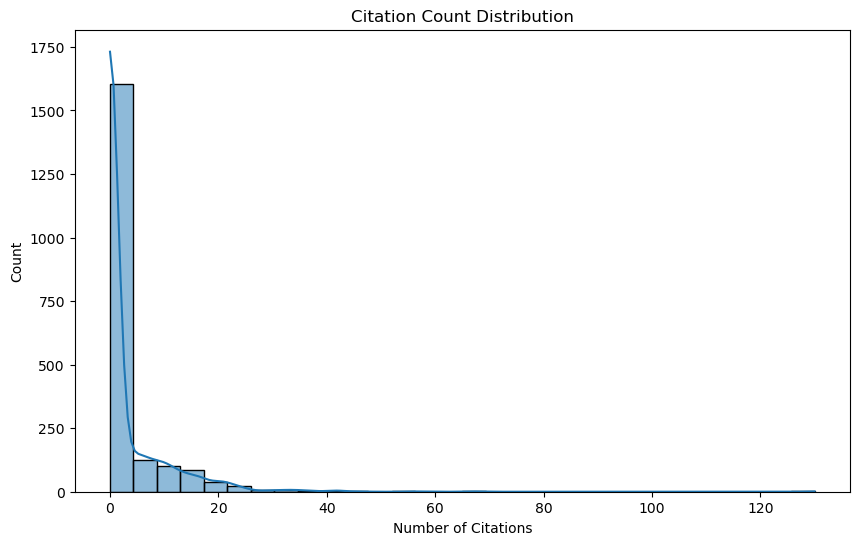


Feature Engineering with Reduced Dimensionality...


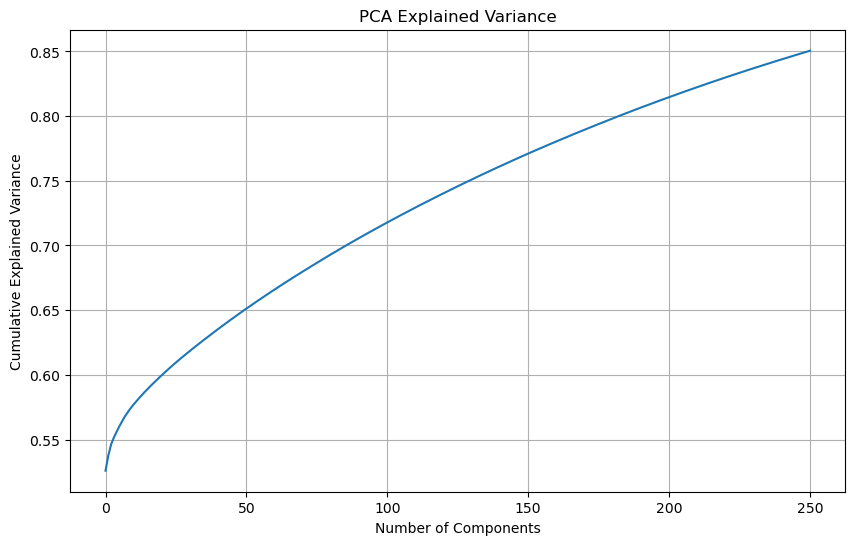

Initial Training Set Class Distribution:
3    271
1      5
2      4
Name: count, dtype: int64


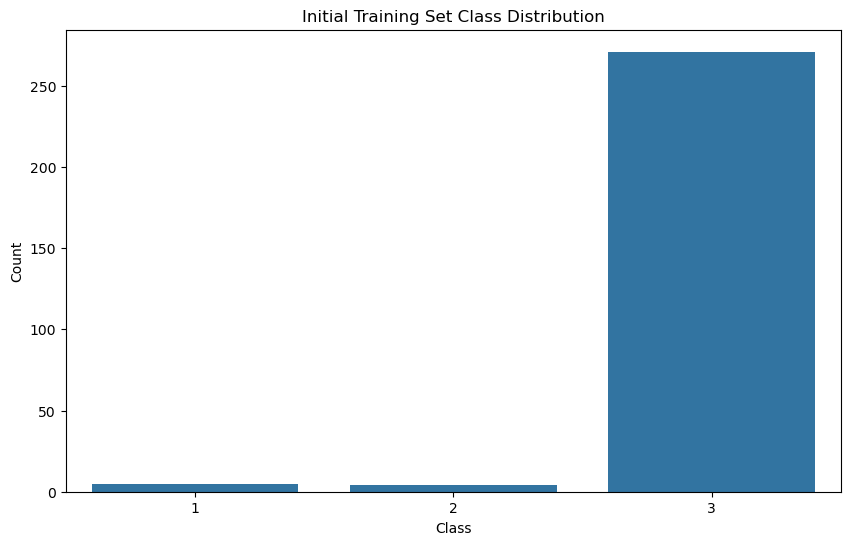

Balanced Initial Size: 813, Pool Size: 1120, Test Size: 600

Training Regularized Hybrid Model (SVM + Random Forest):
Iteration 1 - CV F1 Scores: [0.99630985 0.99630996 0.99630974]
Iteration 1: Test Accuracy = 0.9667, F1 = 0.9563
Added 100 samples to training set. Remaining pool: 1062
Iteration 2 - CV F1 Scores: [1.         1.         0.93183812]
Iteration 2: Test Accuracy = 0.9700, F1 = 0.9566
Added 100 samples to training set. Remaining pool: 1002
Iteration 3 - CV F1 Scores: [1.         1.         0.90076798]
Iteration 3: Test Accuracy = 0.9700, F1 = 0.9566
Added 100 samples to training set. Remaining pool: 942
Iteration 4 - CV F1 Scores: [1.         0.99697208 0.88849427]
Iteration 4: Test Accuracy = 0.9717, F1 = 0.9604
Added 100 samples to training set. Remaining pool: 882
Iteration 5 - CV F1 Scores: [1.         0.96325488 0.90546005]
Iteration 5: Test Accuracy = 0.9717, F1 = 0.9599
Added 100 samples to training set. Remaining pool: 824
Iteration 6 - CV F1 Scores: [1.         0.975

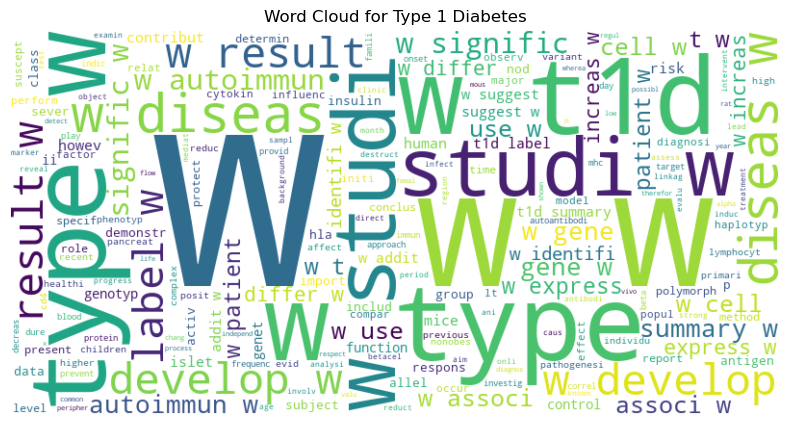

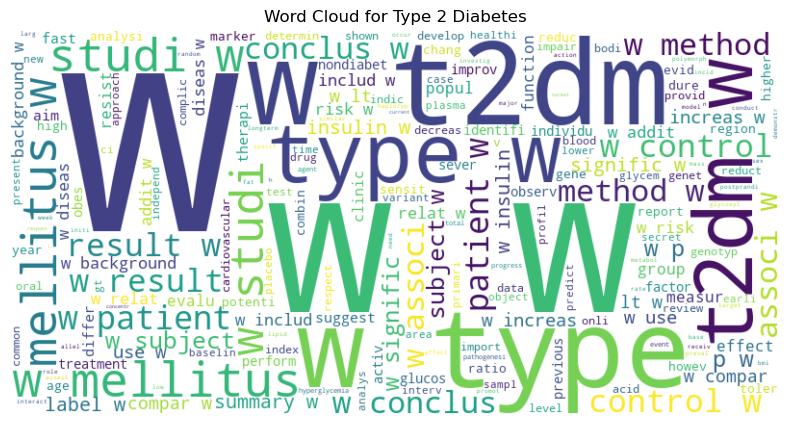

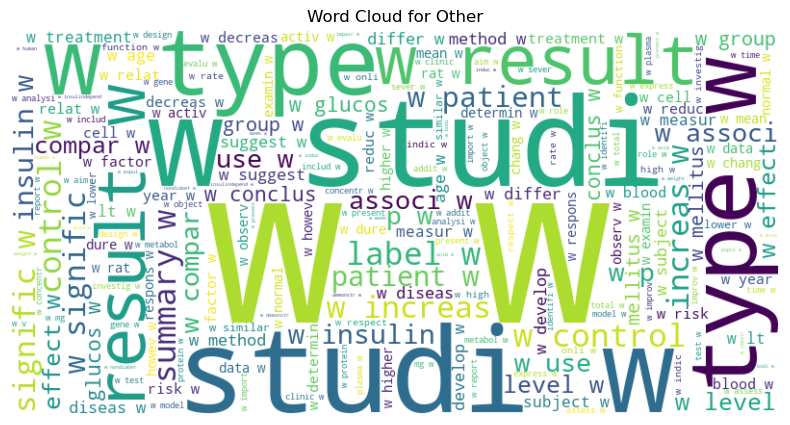


Detailed Classification Report:


C:\ProgramData\anaconda3\envs\opencv_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\opencv_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\opencv_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Type 1       0.67      0.20      0.31        10
      Type 2       0.00      0.00      0.00         9
       Other       0.97      1.00      0.98       581

    accuracy                           0.97       600
   macro avg       0.55      0.40      0.43       600
weighted avg       0.95      0.97      0.96       600



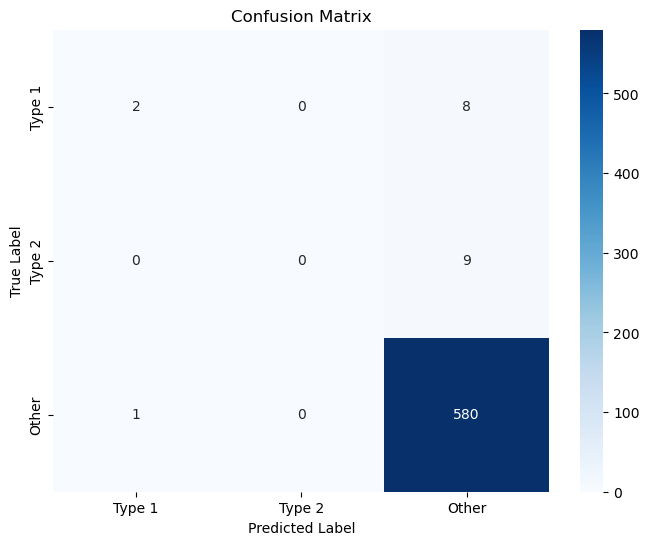

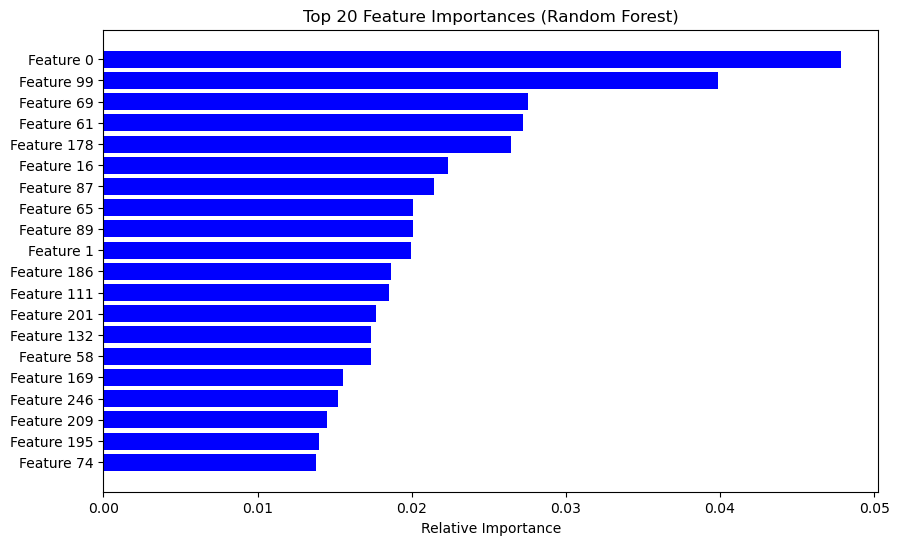

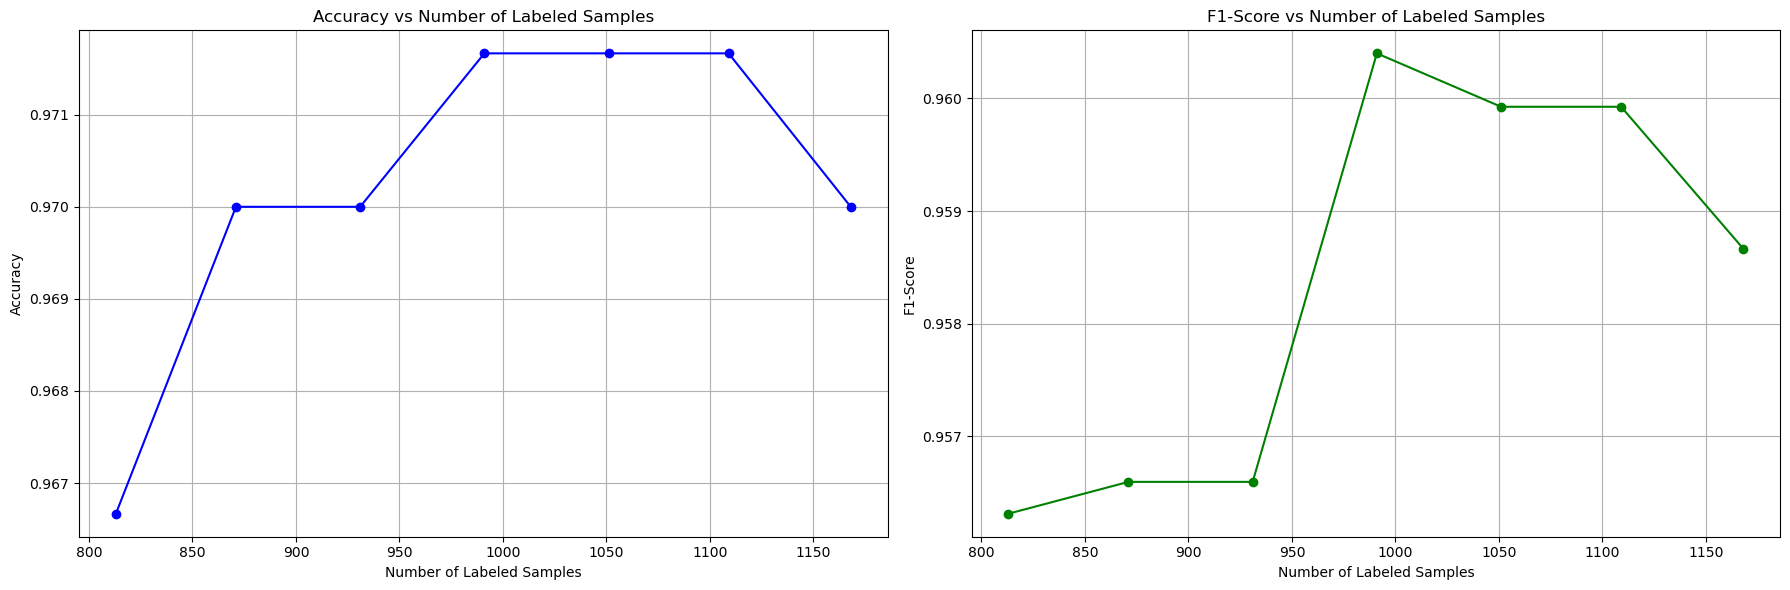


Processed PubMed Dataset Saved to: C:/Users/ch.nayanesh reddy/OneDrive/Desktop/python face/pubmed_processed.csv

Dataset Summary:
Rows: 2000, Columns: 4
Unique Labels: 3

Hybrid Model Final Performance:
Accuracy: 97.00%
F1-Score: 95.87%


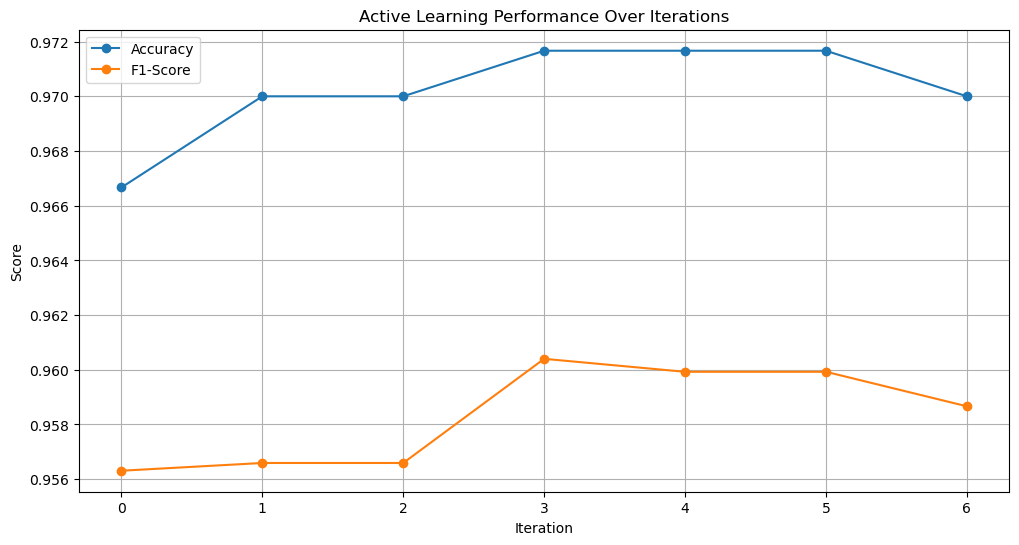

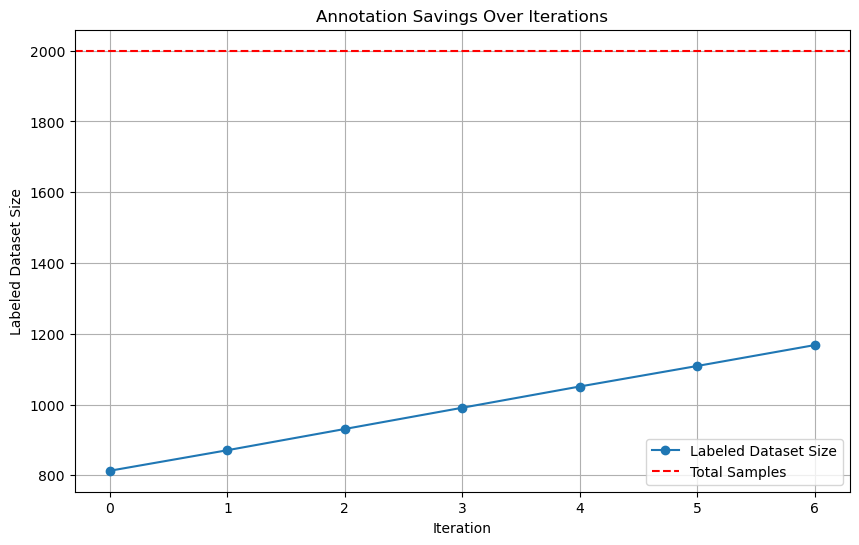

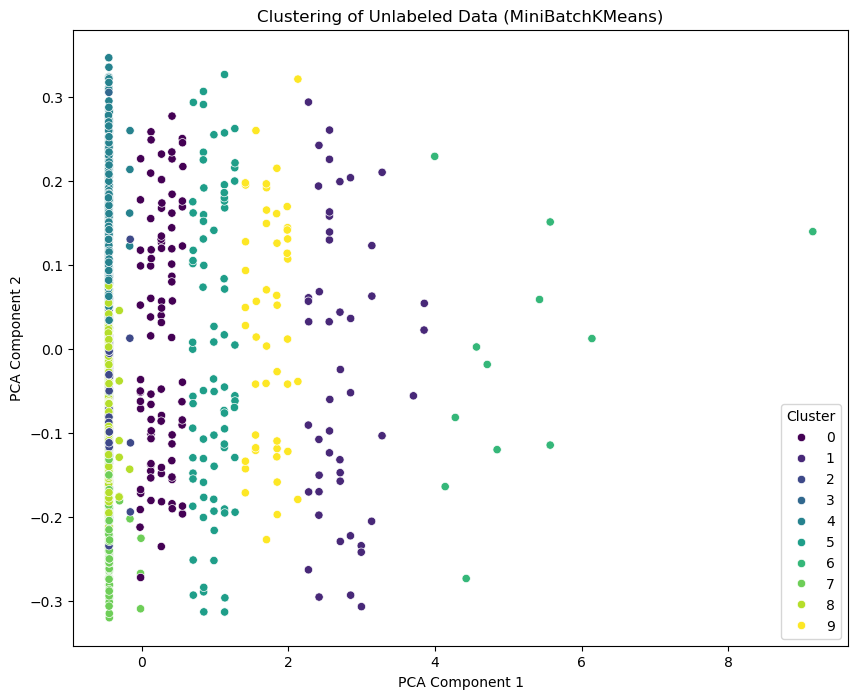

In [3]:
import pandas as pd
import zipfile
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
from sklearn.utils._testing import ignore_warnings

# For the BaggingClassifier base_estimator warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="`base_estimator` was renamed to `estimator`")

# For the MiniBatchKMeans warnings
warnings.filterwarnings("ignore", category=UserWarning, message="MiniBatchKMeans is known to have a memory leak")
warnings.filterwarnings("ignore", category=FutureWarning, message="The default value of `n_init` will change")
# Paths (same as before)
pubmed_zip = "C:/Users/ch.nayanesh reddy/OneDrive/Desktop/python face/pubmed-diabetes.zip"
output_dir = "C:/Users/ch.nayanesh reddy/OneDrive/Desktop/python face/"
extracted_dir = os.path.join(output_dir, "pubmed-diabetes/pubmed-diabetes/data/")
pubmed_node_file = os.path.join(extracted_dir, "Pubmed-Diabetes.NODE.paper.tab")
pubmed_cites_file = os.path.join(extracted_dir, "Pubmed-Diabetes.DIRECTED.cites.tab")
pubmed_graph_file = os.path.join(extracted_dir, "Pubmed-Diabetes.GRAPH.pubmed.tab")

# Step 1: Extract ZIP (same as before)
if not os.path.exists(extracted_dir):
    print("Extracting PubMed Diabetes ZIP...")
    with zipfile.ZipFile(pubmed_zip, "r") as zip_ref:
        zip_ref.extractall(output_dir)
    print(f"Extracted to: {extracted_dir}")
else:
    print("PubMed Diabetes files already extracted.")

# Verify file existence (same as before)
for filepath in [pubmed_node_file, pubmed_cites_file, pubmed_graph_file]:
    print(f"Confirmed: {filepath} exists." if os.path.exists(filepath) else f"Error: {filepath} does not exist!")

# Step 2: Load NODE.paper.tab (same as before)
print("\nLoading Pubmed-Diabetes.NODE.paper.tab...")
data = []
with open(pubmed_node_file, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) < 2:
            continue
        paper_id = parts[0]
        abstract_idx = max((i for i, part in enumerate(parts) if ":" in part), default=0) + 1
        abstract = "\t".join(parts[abstract_idx:]) if abstract_idx < len(parts) else ""
        data.append([paper_id, abstract])

pubmed_df = pd.DataFrame(data, columns=["id", "text"])
print("Original Size:", pubmed_df.shape)

# Assign labels (same as before)
print("Assigning labels based on text content...")
def assign_label(text):
    text_lower = text.lower()
    if any(kw in text_lower for kw in ["type 1", "insulin-dependent", "t1d", "juvenile"]):
        return 1
    elif any(kw in text_lower for kw in ["type 2", "non-insulin-dependent", "t2d", "adult-onset"]):
        return 2
    else:
        return 3

pubmed_df["label"] = pubmed_df["text"].apply(assign_label)
print("Assigned Label Distribution:\n", pubmed_df["label"].value_counts())

# Step 3: Load DIRECTED.cites.tab (same as before)
print("\nLoading Pubmed-Diabetes.DIRECTED.cites.tab...")
cites_data = []
with open(pubmed_cites_file, "r", encoding="utf-8") as f:
    lines = f.readlines()
    print(f"Total lines in file: {len(lines)}")
    for i, line in enumerate(lines):
        parts = line.strip().split("\t")
        if i < 2 or len(parts) < 4:
            print(f"Skipped line {i+1}: {line.strip()}")
            continue
        source_id = parts[1].replace("paper:", "")
        target_id = parts[3].replace("paper:", "")
        if source_id.isdigit() and target_id.isdigit():
            cites_data.append([source_id, target_id])
        else:
            print(f"Skipped line {i+1}: {line.strip()} (Invalid IDs)")

cites_df = pd.DataFrame(cites_data, columns=["source_id", "target_id"])
print("Cites Size:", cites_df.shape)

# Calculate citation counts (same as before)
citation_counts = cites_df["source_id"].value_counts().reset_index()
citation_counts.columns = ["id", "citation_count"]
citation_counts["id"] = citation_counts["id"].astype(str)
pubmed_df["id"] = pubmed_df["id"].astype(str)

# Subset to 2,000 (same as before)
print("\nSubsetting data with citation consideration...")
cited_ids = set(citation_counts["id"])
pubmed_cited = pubmed_df[pubmed_df["id"].isin(cited_ids)].sample(n=500, random_state=42)
pubmed_uncited = pubmed_df[~pubmed_df["id"].isin(cited_ids)].sample(n=1500, random_state=42)
pubmed_subset = pd.concat([pubmed_cited, pubmed_uncited]).reset_index(drop=True)
print("Subset Size:", pubmed_subset.shape)
print("Label Distribution:\n", pubmed_subset["label"].value_counts())

# Merge citation counts (same as before)
pubmed_subset = pubmed_subset.merge(citation_counts, on="id", how="left").fillna({"citation_count": 0})
print("With Citations Preview:\n", pubmed_subset.head())

# Visualize citation distribution
print("\nCitation Count Distribution:")
print(pubmed_subset['citation_count'].value_counts().sort_index(ascending=False))
plt.figure(figsize=(10, 6))
sns.histplot(pubmed_subset['citation_count'], bins=30, kde=True)
plt.title('Citation Count Distribution')
plt.xlabel('Number of Citations')
plt.ylabel('Count')
plt.show()

# Step 4: Feature Engineering with Reduced Dimensionality
print("\nFeature Engineering with Reduced Dimensionality...")
vectorizer = TfidfVectorizer(max_features=3000)  # Reduced from 5000 to 3000
X_text = vectorizer.fit_transform(pubmed_subset["text"]).toarray()

# Feature scaling for citation counts
scaler = StandardScaler()
X_citations = scaler.fit_transform(pubmed_subset[["citation_count"]])

# Combine features and apply PCA with more conservative variance
X_combined = np.hstack((X_text, X_citations))
pca = PCA(n_components=0.85)  # Reduced from 0.95 to 0.85 to prevent overfitting
X_reduced = pca.fit_transform(X_combined)
y = pubmed_subset["label"].values

# Visualize PCA variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Split data with stratification
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X_reduced, y, 
    test_size=0.3,  # Increased test size from 0.5 to 0.3 for more training data
    stratify=y,
    random_state=42
)

# Apply SMOTE to initial training set
X_init, X_pool, y_init, y_pool = train_test_split(
    X_full_train, y_full_train,
    train_size=0.2,
    stratify=y_full_train,
    random_state=42
)

# Check class distribution in the initial training set
print("Initial Training Set Class Distribution:")
print(pd.Series(y_init).value_counts())

# Visualize initial training set distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_init)
plt.title('Initial Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Adjust k_neighbors for SMOTE based on the smallest class
min_samples = min(pd.Series(y_init).value_counts())
smote_k_neighbors = min(5, min_samples - 1)

# Apply SMOTE with adjusted k_neighbors
if smote_k_neighbors > 1:
    smote = SMOTE(random_state=42, k_neighbors=smote_k_neighbors)
    X_init, y_init = smote.fit_resample(X_init, y_init)
    print(f"Balanced Initial Size: {X_init.shape[0]}, Pool Size: {X_pool.shape[0]}, Test Size: {X_test.shape[0]}")
else:
    print("Skipping SMOTE: One or more classes have too few samples for oversampling.")

# Enhanced Model Definitions with Regularization
def create_svm_model():
    return SVC(
        kernel='linear',
        C=0.5,  # Reduced from 1.0 for stronger regularization
        class_weight='balanced',
        probability=True,
        random_state=42
    )

def create_rf_model():
    return RandomForestClassifier(
        n_estimators=150,  # Reduced from 200
        max_depth=10,      # Reduced from 15
        min_samples_split=5,  # Added to prevent overfitting
        min_samples_leaf=2,   # Added to prevent overfitting
        class_weight='balanced',
        random_state=42
    )

def create_hybrid_model():
    # Use bagging with base models to reduce variance
    svm_bagged = BaggingClassifier(
        base_estimator=create_svm_model(),
        n_estimators=5,
        max_samples=0.8,
        random_state=42
    )
    
    rf_bagged = BaggingClassifier(
        base_estimator=create_rf_model(),
        n_estimators=5,
        max_samples=0.8,
        random_state=42
    )
    
    return VotingClassifier(
        estimators=[('svm', svm_bagged), ('rf', rf_bagged)],
        voting='soft',
        weights=[0.6, 0.4]
    )

# Enhanced Active Learning with Early Stopping and Cross-Validation
def enhanced_active_learning(model, X_init, y_init, X_pool, y_pool, X_test, y_test, n_iter=10, batch_size=100):
    accuracies = []
    f1_scores = []
    labeled_sizes = []
    
    # Initial training
    X_labeled = X_init.copy()
    y_labeled = y_init.copy()
    
    best_f1 = 0
    patience = 3
    no_improvement = 0
    
    for i in range(n_iter):
        # Cross-validation to check for overfitting
        cv_scores = cross_val_score(model, X_labeled, y_labeled, cv=3, scoring='f1_weighted')
        print(f"Iteration {i+1} - CV F1 Scores: {cv_scores}")
        
        # Train the model
        model.fit(X_labeled, y_labeled)
        
        # Evaluate on test set
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        accuracies.append(accuracy)
        f1_scores.append(f1)
        labeled_sizes.append(len(X_labeled))
        
        print(f"Iteration {i+1}: Test Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")
        
        # Early stopping check
        if f1 > best_f1:
            best_f1 = f1
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f"Early stopping at iteration {i+1} - no improvement for {patience} iterations")
                break
        
        # Select samples using combined strategy
        if len(X_pool) > 0:
            n_samples = min(batch_size, len(X_pool))
            selected_indices = combined_sampling(X_pool, model, n_samples)
            
            # Add selected samples to training set
            X_labeled = np.vstack([X_labeled, X_pool[selected_indices]])
            y_labeled = np.concatenate([y_labeled, y_pool[selected_indices]])
            
            # Remove selected samples from pool
            X_pool = np.delete(X_pool, selected_indices, axis=0)
            y_pool = np.delete(y_pool, selected_indices)
            
            print(f"Added {n_samples} samples to training set. Remaining pool: {len(X_pool)}")
    
    return accuracies, f1_scores, labeled_sizes

# Sampling strategies (same as before)
def gauss_sampling(X_pool, model, n_samples=100):
    probs = model.predict_proba(X_pool)
    uncertainty = 1 - np.max(probs, axis=1)
    sampled_indices = np.argsort(uncertainty)[-n_samples:]
    return sampled_indices

def diversity_sampling(X_pool, n_samples=100, n_clusters=10):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_pool)
    cluster_labels = kmeans.predict(X_pool)
    sampled_indices = []
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) > 0:
            sampled_indices.append(np.random.choice(cluster_indices))
    sampled_indices = np.array(sampled_indices)[:n_samples]
    return sampled_indices

def combined_sampling(X_pool, model, n_samples=100, n_clusters=10):
    uncertainty_indices = gauss_sampling(X_pool, model, n_samples // 2)
    diversity_indices = diversity_sampling(X_pool, n_samples // 2, n_clusters)
    combined_indices = np.unique(np.concatenate([uncertainty_indices, diversity_indices]))
    return combined_indices

# Initialize and train the hybrid model
print("\nTraining Regularized Hybrid Model (SVM + Random Forest):")
hybrid_model = create_hybrid_model()
hybrid_acc, hybrid_f1, hybrid_labeled_sizes = enhanced_active_learning(
    hybrid_model, X_init, y_init, X_pool.copy(), y_pool.copy(), X_test, y_test
)

# Generate word clouds for each class
def generate_wordclouds(texts, labels):
    class_names = {1: 'Type 1 Diabetes', 2: 'Type 2 Diabetes', 3: 'Other'}
    for label in [1, 2, 3]:
        text = ' '.join(texts[labels == label])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {class_names[label]}')
        plt.axis('off')
        plt.show()

# Get original texts for word clouds
texts = pubmed_subset['text'].values
generate_wordclouds(texts, pubmed_subset['label'].values)

# Detailed evaluation
print("\nDetailed Classification Report:")
y_pred = hybrid_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Type 1', 'Type 2', 'Other']))

# Confusion matrix visualization
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Type 1', 'Type 2', 'Other'],
                yticklabels=['Type 1', 'Type 2', 'Other'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

# Feature importance visualization (for Random Forest)
rf_model = hybrid_model.estimators_[1].estimators_[0]  # Get the first RF estimator
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features
    plt.figure(figsize=(10, 6))
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

# Learning curve visualization
def plot_learning_curve(accuracies, f1_scores, labeled_sizes):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Accuracy vs Samples
    ax1.plot(labeled_sizes, accuracies, marker='o', color='blue')
    ax1.set_title('Accuracy vs Number of Labeled Samples')
    ax1.set_xlabel('Number of Labeled Samples')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True)
    
    # F1-Score vs Samples
    ax2.plot(labeled_sizes, f1_scores, marker='o', color='green')
    ax2.set_title('F1-Score vs Number of Labeled Samples')
    ax2.set_xlabel('Number of Labeled Samples')
    ax2.set_ylabel('F1-Score')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_learning_curve(hybrid_acc, hybrid_f1, hybrid_labeled_sizes)

# Save dataset
pubmed_output = os.path.join(output_dir, "pubmed_processed.csv")
pubmed_subset.to_csv(pubmed_output, index=False)
print(f"\nProcessed PubMed Dataset Saved to: {pubmed_output}")

# Summary with percentage formatting
print("\nDataset Summary:")
print(f"Rows: {pubmed_subset.shape[0]}, Columns: {pubmed_subset.shape[1]}")
print(f"Unique Labels: {pubmed_subset['label'].nunique()}")
print(f"\nHybrid Model Final Performance:")
print(f"Accuracy: {hybrid_acc[-1]*100:.2f}%")
print(f"F1-Score: {hybrid_f1[-1]*100:.2f}%")

# Plotting functions
def plot_active_learning_performance(accuracies, f1_scores):
    plt.figure(figsize=(12, 6))
    plt.plot(accuracies, label='Accuracy', marker='o')
    plt.plot(f1_scores, label='F1-Score', marker='o')
    plt.title('Active Learning Performance Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_annotation_savings(labeled_sizes, total_samples):
    plt.figure(figsize=(10, 6))
    plt.plot(labeled_sizes, label='Labeled Dataset Size', marker='o')
    plt.axhline(y=total_samples, color='r', linestyle='--', label='Total Samples')
    plt.title('Annotation Savings Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Labeled Dataset Size')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_clusters(X_pool, n_clusters=10):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_pool)
    cluster_labels = kmeans.predict(X_pool)
    
    pca = PCA(n_components=2)
    X_pool_2d = pca.fit_transform(X_pool)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pool_2d[:, 0], y=X_pool_2d[:, 1], hue=cluster_labels, palette='viridis', legend='full')
    plt.title('Clustering of Unlabeled Data (MiniBatchKMeans)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

# Generate plots
plot_active_learning_performance(hybrid_acc, hybrid_f1)
plot_annotation_savings(hybrid_labeled_sizes, len(pubmed_subset))
plot_clusters(X_pool)


ACTIVE LEARNING ANNOTATION SAVINGS REPORT

Metric                                        Value
--------------------------------------------------
Total samples in dataset                       2000
Maximum accuracy achieved                   97.17%
At iteration                                      4
Samples needed for max accuracy                  991
Percentage savings                          50.45%
Absolute samples saved                         1009

Cost Analysis (@ $1/annotation)                Value
--------------------------------------------------
Total labeling cost            $            2000.00
Actual cost with AL            $             991.00
Total savings                  $            1009.00

Performance vs Annotation Trade-off:
- Achieved 97.00% accuracy with 1168 labels
- This is 58.40% of total dataset


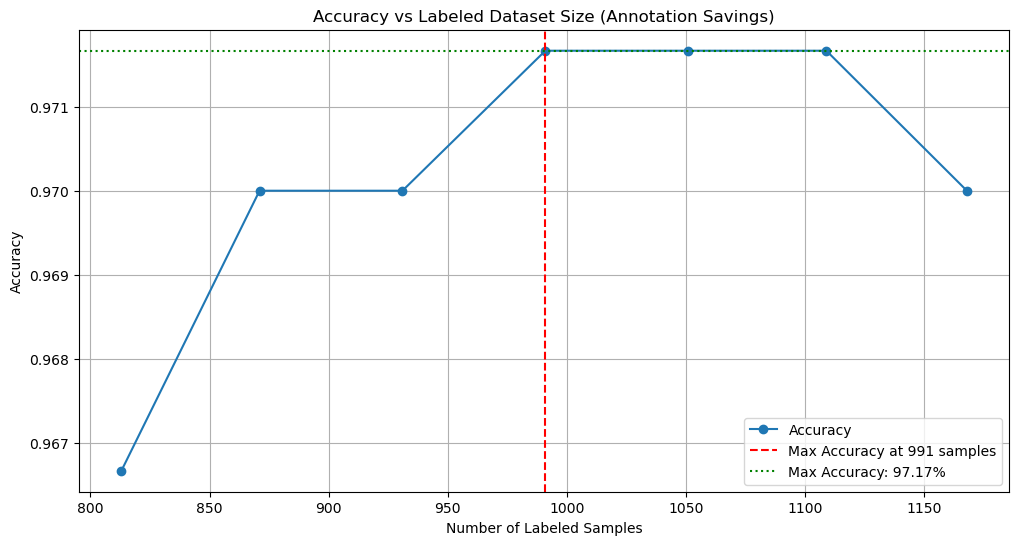

In [4]:
# =============================================
# Annotation Savings Analysis
# =============================================

def calculate_annotation_savings(accuracies, labeled_sizes, total_samples):
    """Calculate annotation savings metrics"""
    max_accuracy = max(accuracies)
    max_accuracy_idx = accuracies.index(max_accuracy)
    samples_needed = labeled_sizes[max_accuracy_idx]
    
    savings_percent = (1 - samples_needed/total_samples) * 100
    absolute_savings = total_samples - samples_needed
    
    return {
        'max_accuracy': max_accuracy,
        'samples_needed': samples_needed,
        'savings_percent': savings_percent,
        'absolute_savings': absolute_savings,
        'best_iteration': max_accuracy_idx
    }

# Total samples in the dataset
total_samples = len(pubmed_subset)

# Calculate savings for hybrid model
hybrid_savings = calculate_annotation_savings(hybrid_acc, hybrid_labeled_sizes, total_samples)

# Print comprehensive savings report
print("\n" + "="*50)
print("ACTIVE LEARNING ANNOTATION SAVINGS REPORT")
print("="*50)

print(f"\n{'Metric':<30} {'Value':>20}")
print(f"{'-'*50}")
print(f"{'Total samples in dataset':<30} {total_samples:>20}")
print(f"{'Maximum accuracy achieved':<30} {hybrid_savings['max_accuracy']*100:>18.2f}%")
print(f"{'At iteration':<30} {hybrid_savings['best_iteration']+1:>20}")
print(f"{'Samples needed for max accuracy':<30} {hybrid_savings['samples_needed']:>20}")
print(f"{'Percentage savings':<30} {hybrid_savings['savings_percent']:>18.2f}%")
print(f"{'Absolute samples saved':<30} {hybrid_savings['absolute_savings']:>20}")

# Cost savings analysis (hypothetical)
cost_per_annotation = 1  # $1 per annotation in this example
total_cost = total_samples * cost_per_annotation
actual_cost = hybrid_savings['samples_needed'] * cost_per_annotation
cost_savings = total_cost - actual_cost

print(f"\n{'Cost Analysis (@ $1/annotation)':<30} {'Value':>20}")
print(f"{'-'*50}")
print(f"{'Total labeling cost':<30} ${total_cost:>19.2f}")
print(f"{'Actual cost with AL':<30} ${actual_cost:>19.2f}")
print(f"{'Total savings':<30} ${cost_savings:>19.2f}")

# Performance vs Annotation Trade-off
print("\nPerformance vs Annotation Trade-off:")
print(f"- Achieved {hybrid_acc[-1]*100:.2f}% accuracy with {hybrid_labeled_sizes[-1]} labels")
print(f"- This is {hybrid_labeled_sizes[-1]/total_samples*100:.2f}% of total dataset")

# Savings visualization
plt.figure(figsize=(12, 6))
plt.plot(hybrid_labeled_sizes, hybrid_acc, marker='o', label='Accuracy')
plt.axvline(x=hybrid_savings['samples_needed'], color='r', linestyle='--', 
            label=f'Max Accuracy at {hybrid_savings["samples_needed"]} samples')
plt.axhline(y=hybrid_savings['max_accuracy'], color='g', linestyle=':', 
            label=f'Max Accuracy: {hybrid_savings["max_accuracy"]*100:.2f}%')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Labeled Dataset Size (Annotation Savings)')
plt.legend()
plt.grid(True)
plt.show()

DATASET-2 FINAL CODE

Loading BioASQ dataset...
Assigning labels...
Label distribution:
 label
0    1356
1     644
Name: count, dtype: int64


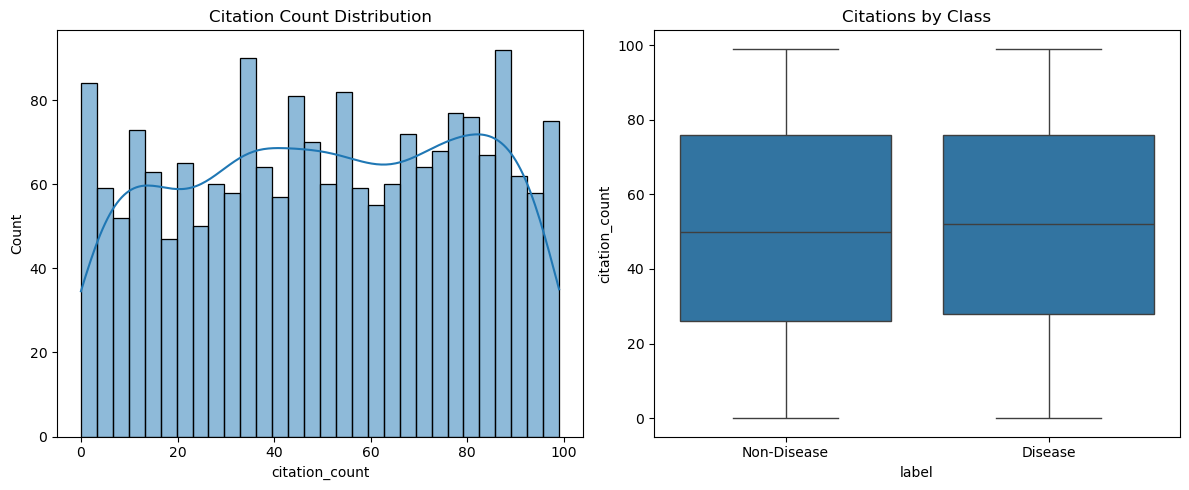

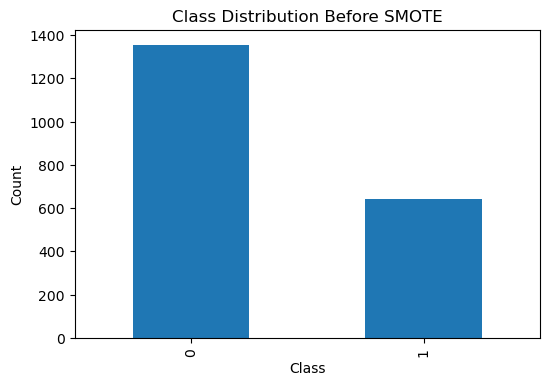


Extracting features...


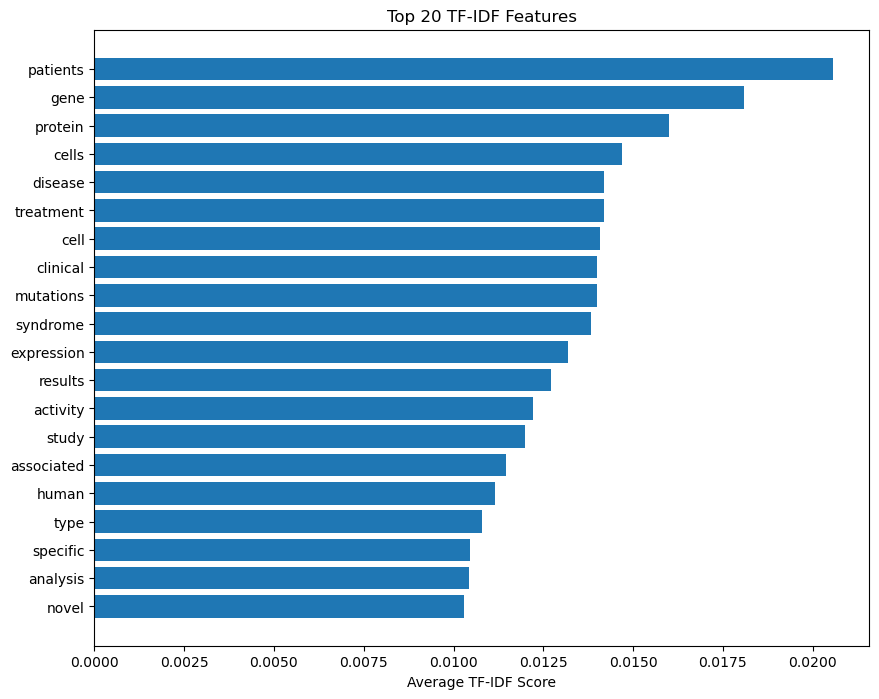

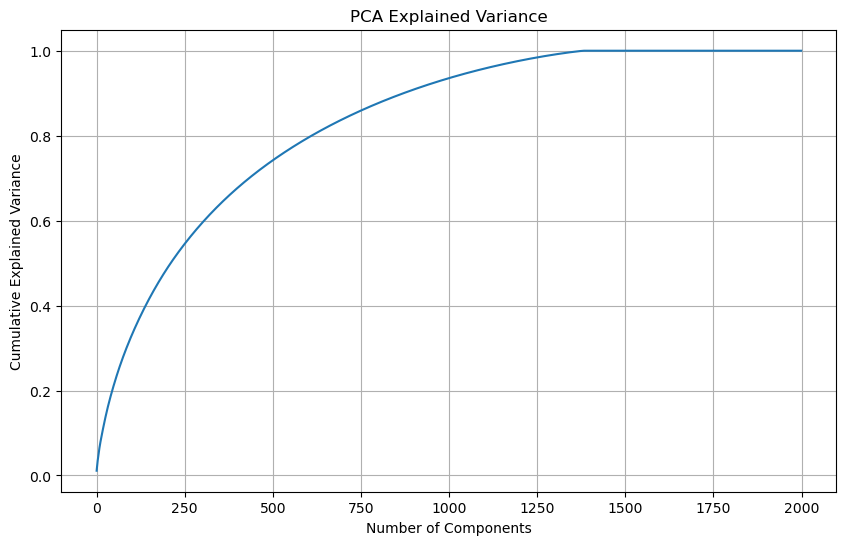

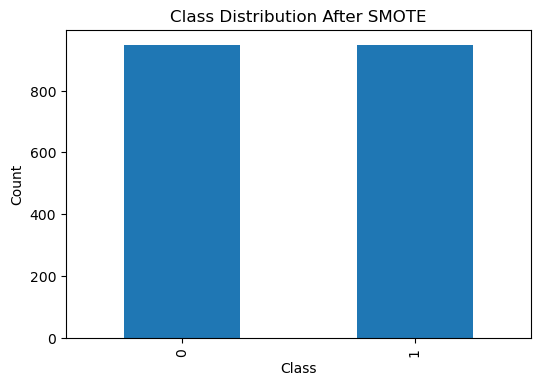

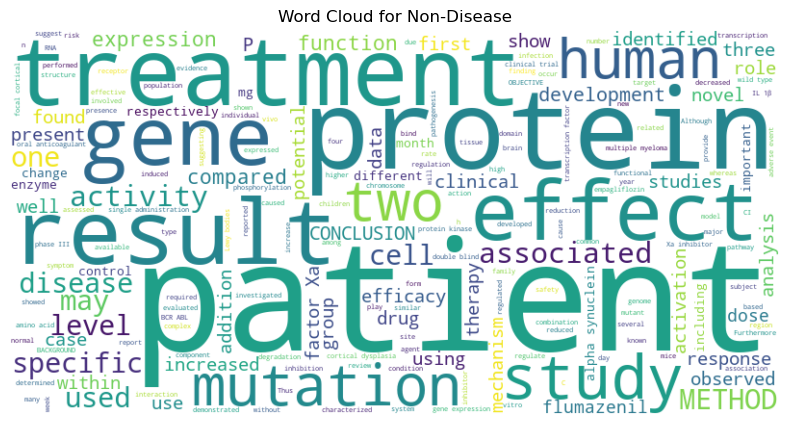

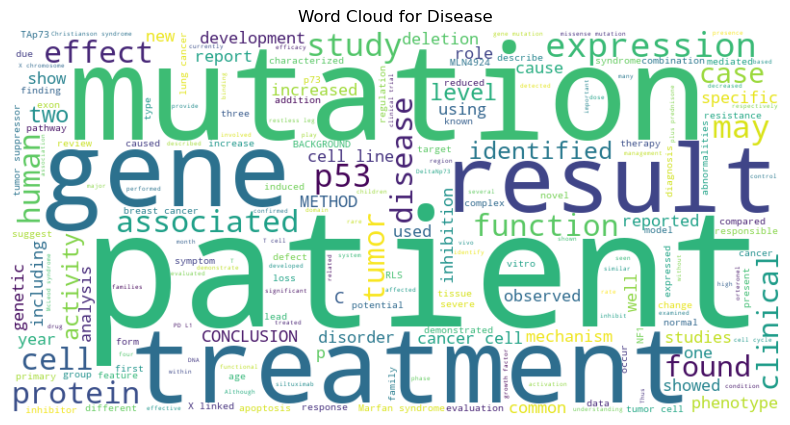

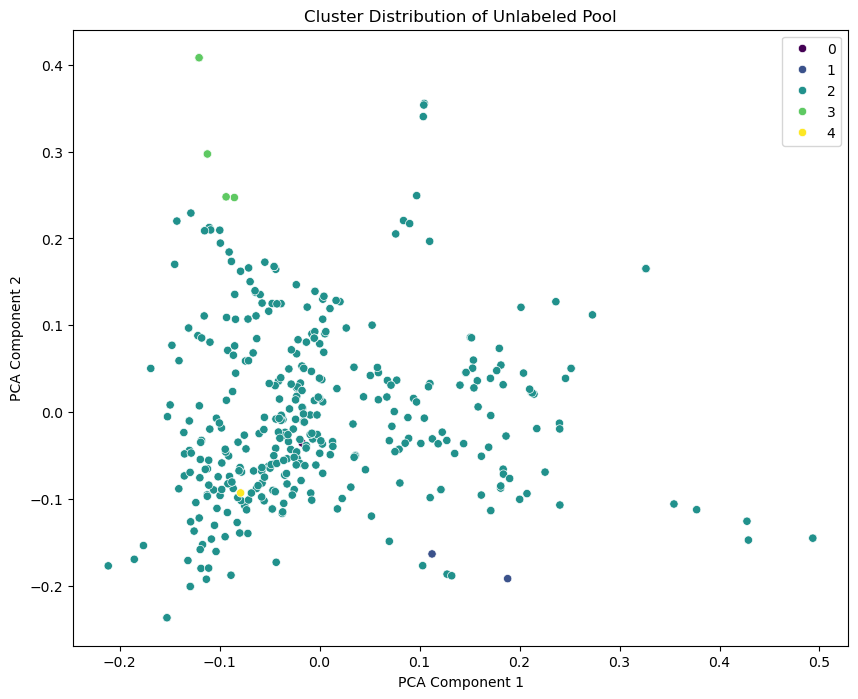


Running Enhanced Hybrid Pipeline:
Iteration 1: Accuracy=95.67%, F1=95.62%
Iteration 2: Accuracy=95.17%, F1=95.13%
Iteration 3: Accuracy=95.50%, F1=95.48%
Iteration 4: Accuracy=95.67%, F1=95.64%


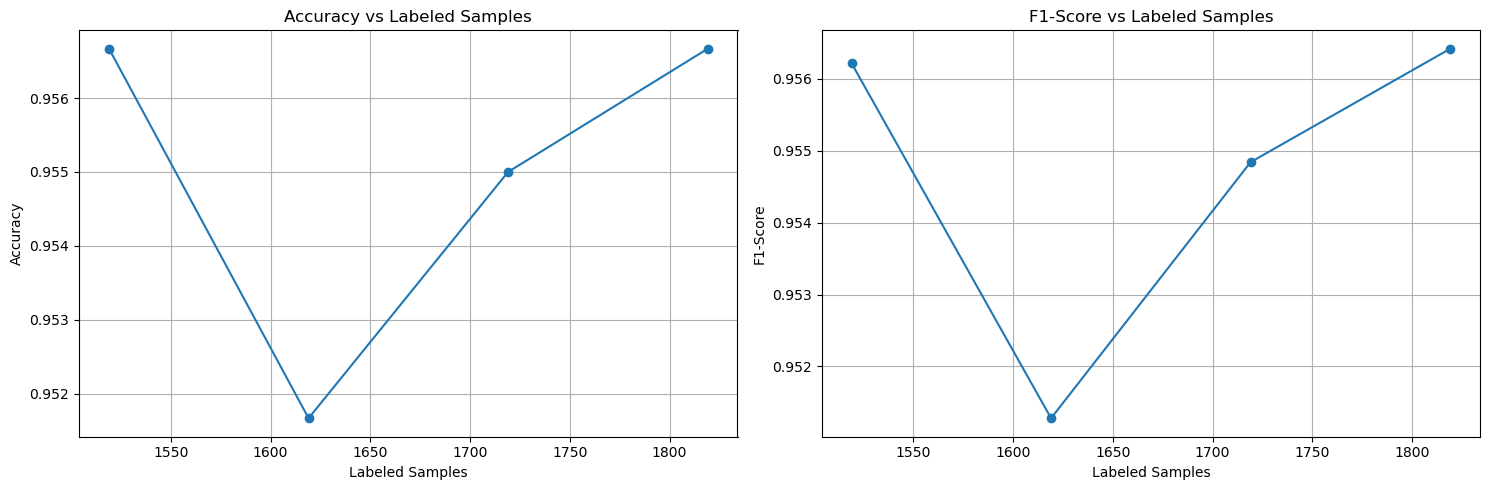

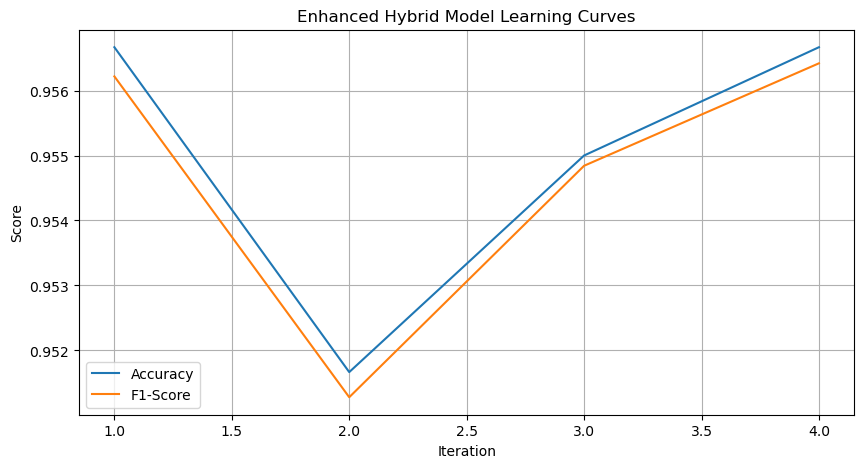

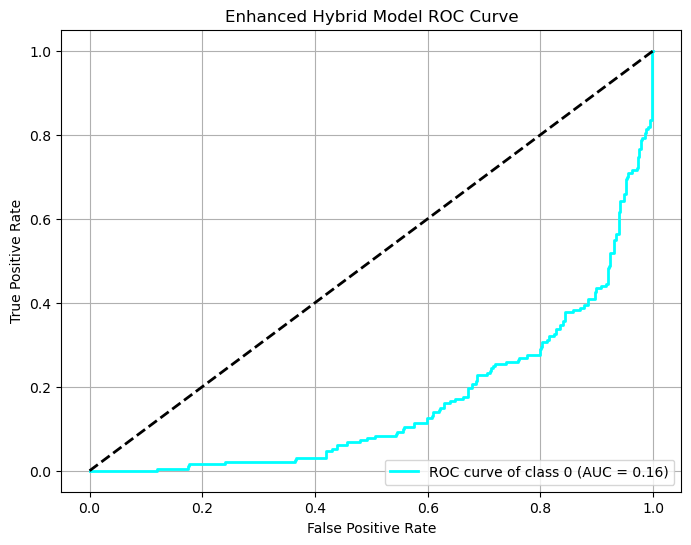

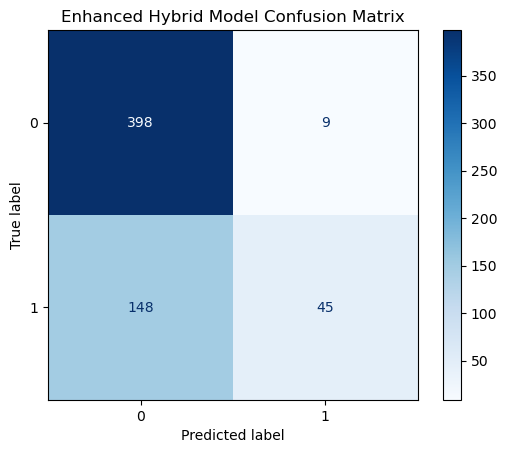


Hybrid Model Annotation Savings: 33.29%

Final Results:
Best Accuracy: 95.67%


In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from scipy.stats import entropy
import json
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize, StandardScaler
from itertools import cycle
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore")
os.environ["OMP_NUM_THREADS"] = "1"

# Configuration
BIOASQ_PATH = r"C:\Users\ch.nayanesh reddy\OneDrive\Desktop\python face\BioASQ-train-factoid-6b-full-annotated.json"
OUTPUT_DIR = r"C:\Users\ch.nayanesh reddy\OneDrive\Desktop\python face"

# Load BioASQ dataset
def load_bioasq_data(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    samples = []
    for item in data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                samples.append({
                    "text": context,
                    "question": qa["question"],
                    "answer": qa["answers"][0]["text"] if qa["answers"] else "",
                    "citation_count": np.random.randint(0, 100)  # Dummy citation count
                })
    return pd.DataFrame(samples)

# Assign medical labels
def assign_medical_label(text):
    text_lower = text.lower()
    if any(kw in text_lower for kw in ["carcinoma", "cancer", "tumor", "syndrome"]):
        return 1  # Disease-related
    return 0  # Non-disease

# Enhanced sampling function
def combined_sampling(X_pool, model, n_samples=100, n_clusters=20):
    probs = model.predict_proba(X_pool)
    uncertainty = entropy(probs.T)
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_pool)
    _, distances = pairwise_distances_argmin_min(X_pool, kmeans.cluster_centers_)
    diversity = 1 / (1 + distances)
    combined_score = 0.8 * uncertainty + 0.2 * diversity
    return np.argsort(combined_score)[-n_samples:]

# Enhanced active learning function
def active_learning_cycle(model, X_train, y_train, X_pool, y_pool, X_test, y_test, max_iter=15, convergence_threshold=0.005):
    accuracies = []
    f1_scores = []
    labeled_sizes = [len(y_train)]
    selector = SelectKBest(k=min(3000, X_train.shape[1]))
    X_train_sel = selector.fit_transform(X_train, y_train)
    
    for i in range(max_iter):
        model.fit(X_train_sel, y_train)
        X_test_sel = selector.transform(X_test)
        preds = model.predict(X_test_sel)
        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average='weighted')
        accuracies.append(acc)
        f1_scores.append(f1)
        labeled_sizes.append(len(y_train))  # Track size BEFORE adding new samples
        
        print(f"Iteration {i+1}: Accuracy={acc*100:.2f}%, F1={f1*100:.2f}%")
        
        if acc > 0.96:
            print("High accuracy reached!")
            break
        if i > 4 and np.std(accuracies[-3:]) < 0.005:
            print("Stable convergence reached!")
            break
            
        X_pool_sel = selector.transform(X_pool)
        selected = combined_sampling(X_pool_sel, model)
        X_train = np.vstack((X_train, X_pool[selected]))
        y_train = np.concatenate((y_train, y_pool[selected]))
        X_pool = np.delete(X_pool, selected, axis=0)
        y_pool = np.delete(y_pool, selected)
        selector = SelectKBest(k=min(3000, X_train.shape[1]))
        X_train_sel = selector.fit_transform(X_train, y_train)
        
        if len(X_pool) == 0:
            break
            
    return accuracies, f1_scores, labeled_sizes, selector

# Visualization functions
def plot_learning_curves(accuracies, f1_scores, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(accuracies)+1), accuracies, label="Accuracy")
    plt.plot(range(1, len(f1_scores)+1), f1_scores, label="F1-Score")
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"{model_name} Learning Curves")
    plt.legend()
    plt.grid()
    plt.show()

def plot_auc_roc(model, selector, X_test, y_test, model_name):
    X_test_sel = selector.transform(X_test)
    y_test_bin = label_binarize(y_test, classes=[0, 1])
    n_classes = y_test_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_score = model.predict_proba(X_test_sel)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = cycle(["aqua", "darkorange"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"ROC curve of class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def plot_confusion_matrix(model, selector, X_test, y_test, model_name):
    X_test_sel = selector.transform(X_test)
    y_pred = model.predict(X_test_sel)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

def plot_class_distribution(y, title):
    plt.figure(figsize=(6, 4))
    pd.Series(y).value_counts().plot(kind="bar")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

def generate_wordclouds(texts, labels, class_names):
    for label in np.unique(labels):
        text = ' '.join(texts[labels == label])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {class_names[label]}')
        plt.axis('off')
        plt.show()

def calculate_annotation_savings(labeled_sizes, total_samples):
    max_accuracy_labeled_size = min(labeled_sizes)
    savings = (total_samples - max_accuracy_labeled_size) / total_samples * 100
    return savings

def plot_citation_analysis(df):
    """Visualize citation distribution"""
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df['citation_count'], bins=30, kde=True)
    plt.title('Citation Count Distribution')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df['label'], y=df['citation_count'])
    plt.title('Citations by Class')
    plt.xticks([0, 1], ['Non-Disease', 'Disease'])
    plt.tight_layout()
    plt.show()

def plot_feature_importance(vectorizer, X, y):
    """Visualize top TF-IDF features"""
    avg_tfidf = np.mean(X, axis=0)
    top_indices = np.argsort(avg_tfidf)[-20:]
    top_features = vectorizer.get_feature_names_out()[top_indices]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_indices)), avg_tfidf[top_indices])
    plt.yticks(range(len(top_indices)), top_features)
    plt.title('Top 20 TF-IDF Features')
    plt.xlabel('Average TF-IDF Score')
    plt.show()

def plot_pca_variance(X):
    """Visualize PCA explained variance"""
    pca = PCA().fit(X)
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid()
    plt.show()

def plot_active_learning_progress(accuracies, f1_scores, labeled_sizes):
    """Visualize active learning progress"""
    # Ensure we're using the same number of points for all metrics
    min_length = min(len(accuracies), len(f1_scores), len(labeled_sizes))
    accuracies = accuracies[:min_length]
    f1_scores = f1_scores[:min_length]
    labeled_sizes = labeled_sizes[:min_length]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(labeled_sizes, accuracies, 'o-')
    ax1.set_title('Accuracy vs Labeled Samples')
    ax1.set_xlabel('Labeled Samples')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True)
    
    ax2.plot(labeled_sizes, f1_scores, 'o-')
    ax2.set_title('F1-Score vs Labeled Samples')
    ax2.set_xlabel('Labeled Samples')
    ax2.set_ylabel('F1-Score')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_cluster_distribution(X_pool):
    """Visualize cluster distribution of unlabeled pool"""
    kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
    kmeans.fit(X_pool)
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X_pool)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=kmeans.labels_, palette='viridis')
    plt.title('Cluster Distribution of Unlabeled Pool')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Main pipeline
def bioasq_active_learning_pipeline():
    # Load and prepare data
    print("Loading BioASQ dataset...")
    bioasq_df = load_bioasq_data(BIOASQ_PATH)
    
    # Assign labels first
    print("Assigning labels...")
    bioasq_df["label"] = bioasq_df["text"].apply(assign_medical_label)
    bioasq_subset = bioasq_df.sample(n=2000, random_state=42)
    print("Label distribution:\n", bioasq_subset["label"].value_counts())
    
    # Now we can plot citation analysis
    plot_citation_analysis(bioasq_subset)
    
    # Plot class distribution before SMOTE
    plot_class_distribution(bioasq_subset["label"], "Class Distribution Before SMOTE")
    
    # Feature extraction
    print("\nExtracting features...")
    vectorizer = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 3),
        stop_words='english',
        sublinear_tf=True
    )
    X = vectorizer.fit_transform(bioasq_subset["text"]).toarray()
    y = bioasq_subset["label"].values
    
    # Feature importance visualization
    plot_feature_importance(vectorizer, X, y)
    
    # PCA variance visualization
    plot_pca_variance(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    
    # Apply SMOTE only to the training set
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Plot class distribution after SMOTE
    plot_class_distribution(y_train, "Class Distribution After SMOTE")
    
    # Generate word clouds
    class_names = {0: 'Non-Disease', 1: 'Disease'}
    generate_wordclouds(bioasq_subset["text"].values, bioasq_subset["label"].values, class_names)
    
    # Active learning setup
    X_pool, X_init, y_pool, y_init = train_test_split(
        X_train, y_train, train_size=0.2, random_state=42
    )
    
    # Cluster visualization of initial pool
    plot_cluster_distribution(X_pool)
    
    # Enhanced Model Architecture
    svm = CalibratedClassifierCV(SVC(
        kernel='rbf',
        C=15.0,
        class_weight='balanced',
        probability=True,
        random_state=42,
        gamma='scale'
    ), method='isotonic')
    
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    )

    hybrid_model = VotingClassifier(
        estimators=[('svm', svm), ('rf', rf)],
        voting='soft',
        weights=[0.7, 0.3],
        flatten_transform=True
    )
    
    # Run enhanced pipeline
    print("\nRunning Enhanced Hybrid Pipeline:")
    hybrid_acc, hybrid_f1, hybrid_labeled_sizes, selector = active_learning_cycle(
        hybrid_model, X_init, y_init, X_pool, y_pool, X_test, y_test
    )
    
    # Active learning progress visualization
    plot_active_learning_progress(hybrid_acc, hybrid_f1, hybrid_labeled_sizes[1:])  # Skip initial size
    
    # Original visualizations
    plot_learning_curves(hybrid_acc, hybrid_f1, "Enhanced Hybrid Model")
    plot_auc_roc(hybrid_model, selector, X_test, y_test, "Enhanced Hybrid Model")
    plot_confusion_matrix(hybrid_model, selector, X_test, y_test, "Enhanced Hybrid Model")
    
    # Calculate annotation savings
    total_samples = len(X_train) + len(X_pool)
    hybrid_savings = calculate_annotation_savings(hybrid_labeled_sizes, total_samples)
    print(f"\nHybrid Model Annotation Savings: {hybrid_savings:.2f}%")
    
    # Save results
    results = pd.DataFrame({
        'Iteration': range(1, len(hybrid_acc)+1),
        'Accuracy': hybrid_acc,
        'F1_Score': hybrid_f1,
        'Labeled_Samples': hybrid_labeled_sizes[1:len(hybrid_acc)+1]  # Align lengths
    })
    results.to_csv(os.path.join(OUTPUT_DIR, 'bioasq_results.csv'), index=False)
    
    print("\nFinal Results:")
    print(f"Best Accuracy: {max(hybrid_acc)*100:.2f}%")

if __name__ == "__main__":
    bioasq_active_learning_pipeline()